In [ ]:
# Mount Google Drive for persistent storage (optional, recommended for Colab)
drive.mount('/content/drive')

# Riot API Key and regions with platform and regional hosts (only LEC, LCK, and LTAN)
API_KEY = 'RGAPI-f652b86a-fd4c-4a20-8977-b7406bf2f083'
REGIONS = {
    'KR': {'platform': 'kr', 'region': 'asia'},
    'EUROPE': {'platform': 'euw1', 'region': 'europe'},
    'AMERICAS': {'platform': 'la1', 'region': 'americas'}
}
TIERS = ['IRON', 'BRONZE', 'SILVER', 'GOLD', 'PLATINUM', 'EMERALD', 'DIAMOND', 'MASTER', 'GRANDMASTER', 'CHALLENGER']
DIVISIONS = ['IV', 'III', 'II', 'I']
TARGET_MATCHES = 10000  # Total matches to collect across selected regions
MATCHES_PER_REGION = TARGET_MATCHES // len(REGIONS)

# Function to fetch players for a given tier
def get_players_by_tier(region_name, tier, division=None, api_key=API_KEY):
    platform = REGIONS[region_name]['platform']
    summoner_ids = []
    if tier in ['CHALLENGER', 'GRANDMASTER', 'MASTER']:
        endpoint = {
            'CHALLENGER': 'challengerleagues',
            'GRANDMASTER': 'grandmasterleagues',
            'MASTER': 'masterleagues'
        }[tier]
        url = f"https://{platform}.api.riotgames.com/lol/league/v4/{endpoint}/by-queue/RANKED_SOLO_5x5?api_key={api_key}"
    else:
        url = f"https://{platform}.api.riotgames.com/lol/league/v4/entries/RANKED_SOLO_5x5/{tier}/{division}?api_key={api_key}"

    while True:
        resp = requests.get(url)
        if resp.status_code == 200:
            data = resp.json()
            if tier in ['CHALLENGER', 'GRANDMASTER', 'MASTER']:
                summoner_ids.extend([entry['summonerId'] for entry in data['entries']][:10])  # Sample 10
            else:
                summoner_ids.extend([entry['summonerId'] for entry in data][:10])  # Sample 10
            break
        elif resp.status_code == 429:
            wait_time = int(resp.headers.get('Retry-After', 10))
            print(f"Rate limited for {tier} {division or ''} in {region_name}. Waiting {wait_time} seconds...")
            time.sleep(wait_time)
        else:
            print(f"Error fetching players for {tier} {division or ''} in {region_name}: {resp.status_code}")
            break
    return summoner_ids

# Function to fetch players across all tiers
def get_all_players(region_name, api_key):
    all_players = []
    for tier in TIERS:
        if tier in ['MASTER', 'GRANDMASTER', 'CHALLENGER']:
            players = get_players_by_tier(region_name, tier)
            all_players.extend([(sid, tier) for sid in players])
        else:
            for division in DIVISIONS:
                players = get_players_by_tier(region_name, tier, division)
                all_players.extend([(sid, f"{tier} {division}") for sid in players])
    return list(set(all_players))  # Remove duplicates with tier labels

    # Function to fetch match IDs for a player using regional host
def get_match_ids(puuid, region_name, count, api_key):
    region = REGIONS[region_name]['region']
    url = (
        f"https://{region}.api.riotgames.com/lol/match/v5/matches/by-puuid/"
        f"{puuid}/ids?type=ranked&start=0&count={count}&api_key={api_key}"
    )
    while True:
        resp = requests.get(url)
        if resp.status_code == 200:
            return resp.json()
        elif resp.status_code == 429:
            wait_time = int(resp.headers.get('Retry-After', 10))
            print(f"Rate limited for match IDs in {region_name}. Waiting {wait_time} seconds...")
            time.sleep(wait_time)
        else:
            print(f"Error fetching match IDs in {region_name}: {resp.status_code}")
            return []

# Function to convert summoner ID to puuid using platform host
def get_puuid_from_summoner_id(region_name, summoner_id, api_key):
    platform = REGIONS[region_name]['platform']
    url = f"https://{platform}.api.riotgames.com/lol/summoner/v4/summoners/{summoner_id}?api_key={api_key}"
    while True:
        resp = requests.get(url)
        if resp.status_code == 200:
            return resp.json()['puuid']
        elif resp.status_code == 429:
            wait_time = int(resp.headers.get('Retry-After', 10))
            print(f"Rate limited for puuid in {region_name}. Waiting {wait_time} seconds...")
            time.sleep(wait_time)
        else:
            print(f"Error fetching puuid in {region_name}: {resp.status_code}")
            return None

# Function to fetch detailed match data using regional host
def get_match_data(region_name, match_id, api_key):
    region = REGIONS[region_name]['region']
    url = f"https://{region}.api.riotgames.com/lol/match/v5/matches/{match_id}?api_key={api_key}"
    while True:
      try:
          resp = requests.get(url)
          if resp.status_code == 200:
              return resp.json()
          elif resp.status_code == 429:
              wait_time = int(resp.headers.get('Retry-After', 10))
              print(f"Rate limited for match data in {region_name}. Waiting {wait_time} seconds...")
              time.sleep(wait_time)
          else:
              print(f"Error fetching match {match_id} in {region_name}: {resp.status_code}")
              return None
      except requests.exceptions.ConnectionError as e: # Catch connection errors
            print(f"Connection error: {e}. Retrying in 5 seconds...")
            time.sleep(5) # Wait before retrying
      except requests.exceptions.RequestException as e: # catch any other request errors
            print(f"Request Exception: {e}. Retrying in 5 seconds...")
            time.sleep(5)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Function to extract features from match data, including Dragon and Baron Takedowns
def collect_match_stats(region_name, match_id, tier, api_key):
    match_data = get_match_data(region_name, match_id, api_key)
    if not match_data or 'info' not in match_data:
        return None

    game_duration = match_data['info']['gameDuration'] / 60  # Convert to minutes
    stats = []

    # Team-level objective totals for fallback
    team_stats = match_data['info']['teams']
    blue_team = team_stats[0] if team_stats[0]['teamId'] == 100 else team_stats[1]
    red_team = team_stats[1] if team_stats[1]['teamId'] == 200 else team_stats[0]
    blue_dragons = blue_team['objectives']['dragon']['kills']
    red_dragons = red_team['objectives']['dragon']['kills']
    blue_barons = blue_team['objectives']['baron']['kills']
    red_barons = red_team['objectives']['baron']['kills']

    for participant in match_data['info']['participants']:
        gold_per_min = participant['goldEarned'] / game_duration if game_duration > 0 else 0
        damage_per_min = participant['totalDamageDealtToChampions'] / game_duration if game_duration > 0 else 0
        vision_per_min = participant['visionScore'] / game_duration if game_duration > 0 else 0
        deaths = max(participant['deaths'], 1)  # Avoid division by zero
        kda = (participant['kills'] + participant['assists']) / deaths
        items_bought = [participant[f'item{i}'] for i in range(7)]
        legendary_items = participant['challenges'].get('legendaryItemUsed', [])

        # Use player-specific takedowns if available; fallback to team totals
        dragon_takedowns = participant.get('dragonTakedowns', blue_dragons if participant['teamId'] == 100 else red_dragons)
        baron_takedowns = participant.get('baronTakedowns', blue_barons if participant['teamId'] == 100 else red_barons)

        stats.append({
            'Match ID': match_id,
            'Region': region_name,
            'Game Duration': game_duration,
            'Role': participant['teamPosition'],
            'KDA': kda,
            'Gold Per Minute': gold_per_min,
            'Damage Per Minute': damage_per_min,
            'Vision Per Minute': vision_per_min,
            'Turret Takedowns': participant.get('turretTakedowns', 0),
            'Dragon Takedowns': dragon_takedowns,
            'Baron Takedowns': baron_takedowns,
            'Win': 1 if participant['win'] else 0,
            'Items Bought': items_bought,
            'Legendary Items': legendary_items
        })

    # Team differences
    gold_diff = sum(p['goldEarned'] for p in match_data['info']['participants'] if p['teamId'] == 100) - \
                sum(p['goldEarned'] for p in match_data['info']['participants'] if p['teamId'] == 200)
    turret_diff = blue_team['objectives']['tower']['kills'] - red_team['objectives']['tower']['kills']
    dragon_diff = blue_dragons - red_dragons
    baron_diff = blue_barons - red_barons

    for stat in stats:
        stat['Gold Difference'] = gold_diff
        stat['Turret Difference'] = turret_diff
        stat['Dragon Difference'] = dragon_diff
        stat['Baron Difference'] = baron_diff

    return stats

# Collect solo queue data
all_stats = []
matches_collected = 0

for region_name in REGIONS.keys():
    print(f"Collecting data from {region_name}...")
    summoner_ids_with_tiers = get_all_players(region_name, API_KEY)
    match_ids_set = set()

    for summoner_id, tier in summoner_ids_with_tiers:
        puuid = get_puuid_from_summoner_id(region_name, summoner_id, API_KEY)
        if not puuid:
            continue
        match_ids = get_match_ids(puuid, region_name, 20, API_KEY)
        match_ids_set.update(match_ids)
        if len(match_ids_set) >= MATCHES_PER_REGION:
            break

    match_ids_list = list(match_ids_set)[:MATCHES_PER_REGION]
    for i, match_id in enumerate(match_ids_list, 1):
        tier = summoner_ids_with_tiers[0][1]  # Approximate tier (first summoner’s tier)
        print(f"Processing {region_name} match {i}/{MATCHES_PER_REGION}: {match_id}")
        match_stats = collect_match_stats(region_name, match_id, tier, API_KEY)
        if match_stats:
            all_stats.extend(match_stats)
            matches_collected += 1
        time.sleep(1.2)

    print(f"Collected {matches_collected} so far...")

In [ ]:
# Save all collected data to a CSV file
df = pd.DataFrame(all_stats)
df.to_csv('/content/drive/My Drive/soloq_match_stats.csv', index=False)
print(f"Total matches processed: {matches_collected}. Data saved to 'soloq_match_stats.csv'")

Total matches processed: 9998. Data saved to 'soloq_match_stats.csv'


In [11]:
import requests
import time
import json
import datetime
import plotly.graph_objects as go
import plotly.express as px
from IPython.display import display, HTML, clear_output
import warnings
import pandas as pd
from google.colab import drive
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

 # Combine match data Soloq and Pro

In [12]:
# Combine match data Solo Queue and Pro
def combine_soloq_pro_data():
    # Load the datasets
    pro_df = pd.read_csv("/content/drive/My Drive/2025_LoL_esports_match_data_from_OraclesElixir.csv")
    solo_df = pd.read_csv("/content/drive/My Drive/soloq_match_stats.csv")

    # Filter for target leagues: LEC, LCK, LTA
    target_leagues = ['LEC', 'LCK', 'LTA']
    filtered_pro_df = pro_df[pro_df['league'].isin(target_leagues)]

    print("Filtered Pro Play Counts by League:")
    print(filtered_pro_df['league'].value_counts())

    # Save filtered data
    filtered_pro_df.to_csv('/content/drive/My Drive/filtered_2025_proplay.csv', index=False)
    print(f"Filtered pro play data saved. Total matches: {len(filtered_pro_df)}")

    # Process player rows: select participantid between 1 and 10 (i.e., individual players)
    player_df = filtered_pro_df[filtered_pro_df['participantid'].between(1, 10)].copy()

    # Map game id and region appropriately
    player_df['Match ID'] = player_df['gameid']

    # Map leagues to regions: LCK -> KR, LTA -> AMERICA, LEC -> EUROPE
    region_mapping = {'LCK': 'KR', 'LTA': 'AMERICAS', 'LEC': 'EUROPE'}
    player_df['Region'] = player_df['league'].map(region_mapping)

    # Convert gamelength from seconds to minutes
    player_df['Game Duration'] = player_df['gamelength'] / 60

    # Role mapping: change utility to support; ensure consistency by converting to uppercase
    role_mapping = {'top': 'TOP', 'jng': 'JUNGLE', 'mid': 'MIDDLE', 'bot': 'BOTTOM', 'sup': 'UTILITY'}
    player_df['Role'] = player_df['position'].map(role_mapping)

    # Compute KDA, ensuring deaths are at least 1
    player_df['KDA'] = (player_df['kills'] + player_df['assists']) / player_df['deaths'].clip(lower=1)

    # Map other performance metrics
    player_df['Gold Per Minute'] = player_df['earned gpm']
    player_df['Damage Per Minute'] = player_df['dpm']
    player_df['Vision Per Minute'] = player_df['vspm']

    # Determine side (Blue/Red) based on participant ID
    player_df['Side'] = player_df['participantid'].apply(lambda x: 'Blue' if x <= 5 else 'Red')

    # Extract team-level objectives for Blue team (participantid == 100)
    blue_obj = filtered_pro_df[filtered_pro_df['participantid'] == 100][['gameid', 'towers', 'dragons', 'barons']].copy()
    blue_obj = blue_obj.rename(columns={'towers': 'blue_towers', 'dragons': 'blue_dragons', 'barons': 'blue_barons'})

    # Extract team-level objectives for Red team (participantid == 200)
    red_obj = filtered_pro_df[filtered_pro_df['participantid'] == 200][['gameid', 'opp_towers', 'opp_dragons', 'opp_barons']].copy()
    red_obj = red_obj.rename(columns={'opp_towers': 'red_towers', 'opp_dragons': 'red_dragons', 'opp_barons': 'red_barons'})

    # Merge team objectives on gameid
    team_obj = pd.merge(blue_obj, red_obj, on='gameid', how='inner')

    # Merge team objectives into the pro player dataframe on gameid
    player_df = player_df.merge(team_obj, left_on='gameid', right_on='gameid', how='left')

    # Assign team-level objective values to individual players based on their 'side'
    player_df['Turret Takedowns'] = player_df.apply(lambda row: row['blue_towers'] if row['Side'].strip().lower() == 'blue'
                                                    else row['red_towers'], axis=1)
    player_df['Dragon Takedowns'] = player_df.apply(lambda row: row['blue_dragons'] if row['Side'].strip().lower() == 'blue'
                                                    else row['red_dragons'], axis=1)
    player_df['Baron Takedowns'] = player_df.apply(lambda row: row['blue_barons'] if row['Side'].strip().lower() == 'blue'
                                                    else row['red_barons'], axis=1)

    # Compute Gold Difference from team totals
    blue_gold = filtered_pro_df[filtered_pro_df['participantid'] == 100][['gameid', 'totalgold']].rename(columns={'totalgold': 'blue_totalgold'})
    red_gold = filtered_pro_df[filtered_pro_df['participantid'] == 200][['gameid', 'totalgold']].rename(columns={'totalgold': 'red_totalgold'})
    team_gold = blue_gold.merge(red_gold, on='gameid', how='inner')
    team_gold['Gold Difference'] = team_gold['blue_totalgold'] - team_gold['red_totalgold']
    player_df = player_df.merge(team_gold[['gameid', 'Gold Difference']], on='gameid', how='left')

    # Compute other differences using available columns from pro data
    player_df['Turret Difference'] = player_df.apply(
        lambda row: row['towers'] - row['opp_towers'] if row['Side'].strip().lower() == 'blue'
                    else row['opp_towers'] - row['towers'], axis=1
    )
    player_df['Dragon Difference'] = player_df.apply(
        lambda row: row['dragons'] - row['opp_dragons'] if row['Side'].strip().lower() == 'blue'
                    else row['opp_dragons'] - row['dragons'], axis=1
    )
    player_df['Baron Difference'] = player_df.apply(
        lambda row: row['barons'] - row['opp_barons'] if row['Side'].strip().lower() == 'blue'
                    else row['opp_barons'] - row['barons'], axis=1
    )

    # Set Win from result column
    player_df['Win'] = player_df['result']

    # Set Items Bought and Legendary Items to empty lists (as strings)
    player_df['Items Bought'] = '[]'
    player_df['Legendary Items'] = '[]'

    # Handle missing values
    # For numerical columns, fill with mean
    numerical_cols = player_df.select_dtypes(include=['int64', 'float64']).columns
    for col in numerical_cols:
        player_df[col] = player_df[col].fillna(player_df[col].mean())

    # For categorical columns, fill with most frequent value
    categorical_cols = player_df.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        # Check if mode is not empty before filling
        if player_df[col].mode().shape[0] > 0:
            player_df[col] = player_df[col].fillna(player_df[col].mode()[0])
        else:
            # Handle case where mode is empty (e.g., all NaN values)
            player_df[col] = player_df[col].fillna('Unknown')

    # Select columns that match the solo queue data attributes
    solo_columns = [
        'Match ID', 'Region', 'Game Duration', 'Role', 'KDA', 'Gold Per Minute', 'Damage Per Minute',
        'Vision Per Minute', 'Turret Takedowns', 'Dragon Takedowns', 'Baron Takedowns', 'Win', 'Items Bought',
        'Legendary Items', 'Gold Difference', 'Turret Difference', 'Dragon Difference', 'Baron Difference'
    ]
    pro_player_df = player_df[solo_columns]

    # Ensure region label for NA is set; fill missing regions with 'AMERICAS'
    solo_df['Region'] = solo_df['Region'].fillna('AMERICAS')

    # If roles in solo_df are not uppercase, convert them to uppercase for consistency
    solo_df['Role'] = solo_df['Role'].str.upper()

    # Combine the pro play and solo queue data
    combined_df = pd.concat([solo_df, pro_player_df], ignore_index=True)

    # Save the combined dataset
    combined_df.to_csv('/content/drive/My Drive/Complete_match_data(solo+pro).csv', index=False)
    print(f"Combined data saved. Total records: {len(combined_df)}")

    return combined_df

# To execute the data integration
combined_df = combine_soloq_pro_data()

<ipython-input-12-36197725ec15>:4: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  pro_df = pd.read_csv("/content/drive/My Drive/2025_LoL_esports_match_data_from_OraclesElixir.csv")
<ipython-input-12-36197725ec15>:5: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  solo_df = pd.read_csv("/content/drive/My Drive/soloq_match_stats.csv")


Filtered Pro Play Counts by League:
league
LCK    1308
LEC     864
LTA     216
Name: count, dtype: int64
Filtered pro play data saved. Total matches: 2388
Combined data saved. Total records: 102124


# BASIC DATA ENGINEERING

# Phase 2


Initial dataset size: (102124, 18)
Removed 501 rows with missing Role values (likely from arena mode or forfeited games)
Remaining dataset size: (101623, 18)

Remaining Missing Values:
Match ID                0
Region                  0
Game Duration           0
Role                    0
KDA                     0
Gold Per Minute         0
Damage Per Minute       0
Vision Per Minute       0
Turret Takedowns        0
Dragon Takedowns        0
Baron Takedowns         0
Win                     0
Items Bought            0
Legendary Items         0
Gold Difference         0
Turret Difference    1990
Dragon Difference    1990
Baron Difference        0
dtype: int64

Missing Values After Handling:
Match ID             0
Region               0
Game Duration        0
Role                 0
KDA                  0
Gold Per Minute      0
Damage Per Minute    0
Vision Per Minute    0
Turret Takedowns     0
Dragon Takedowns     0
Baron Takedowns      0
Win                  0
Items Bought         0
Leg

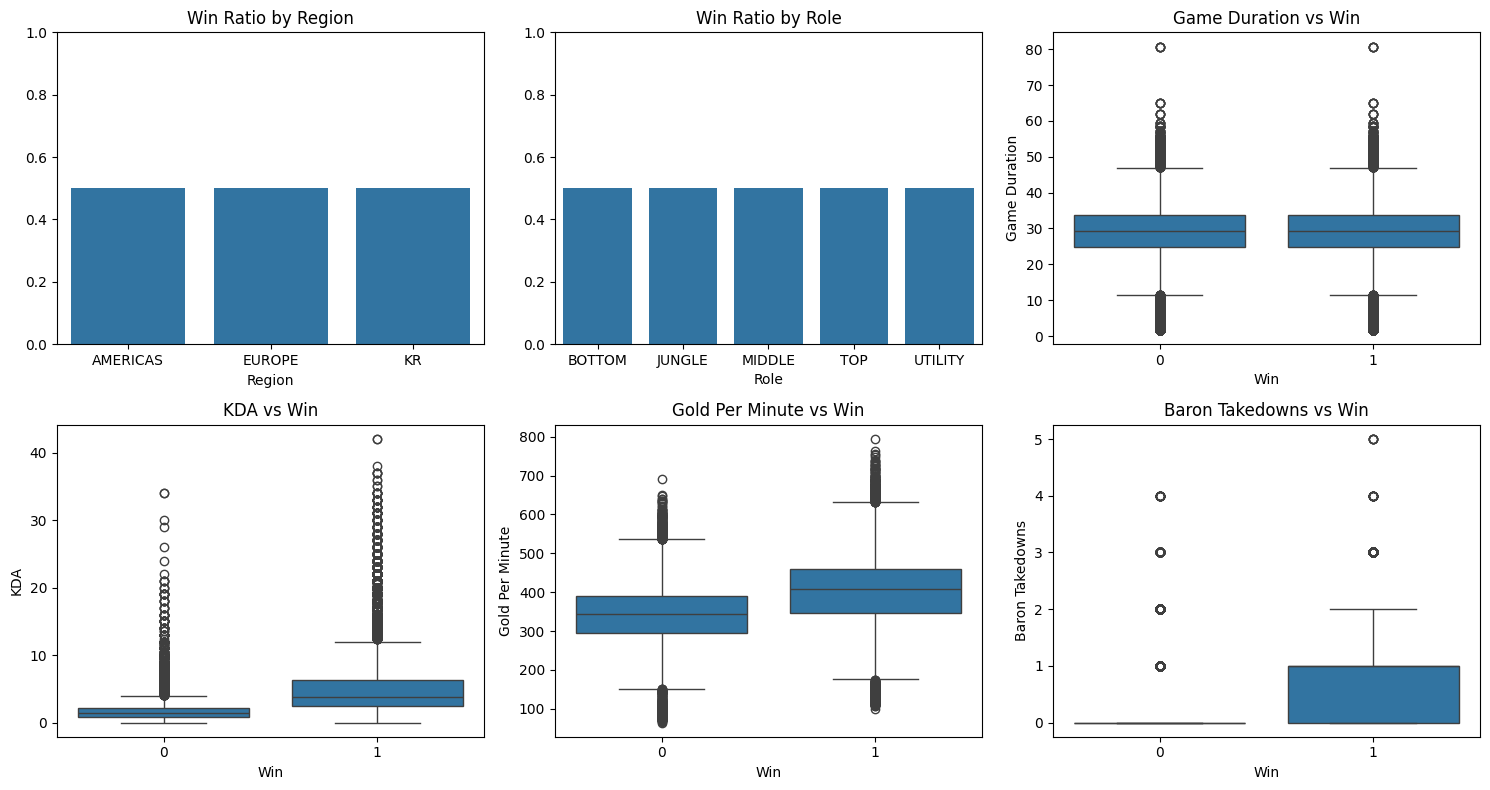

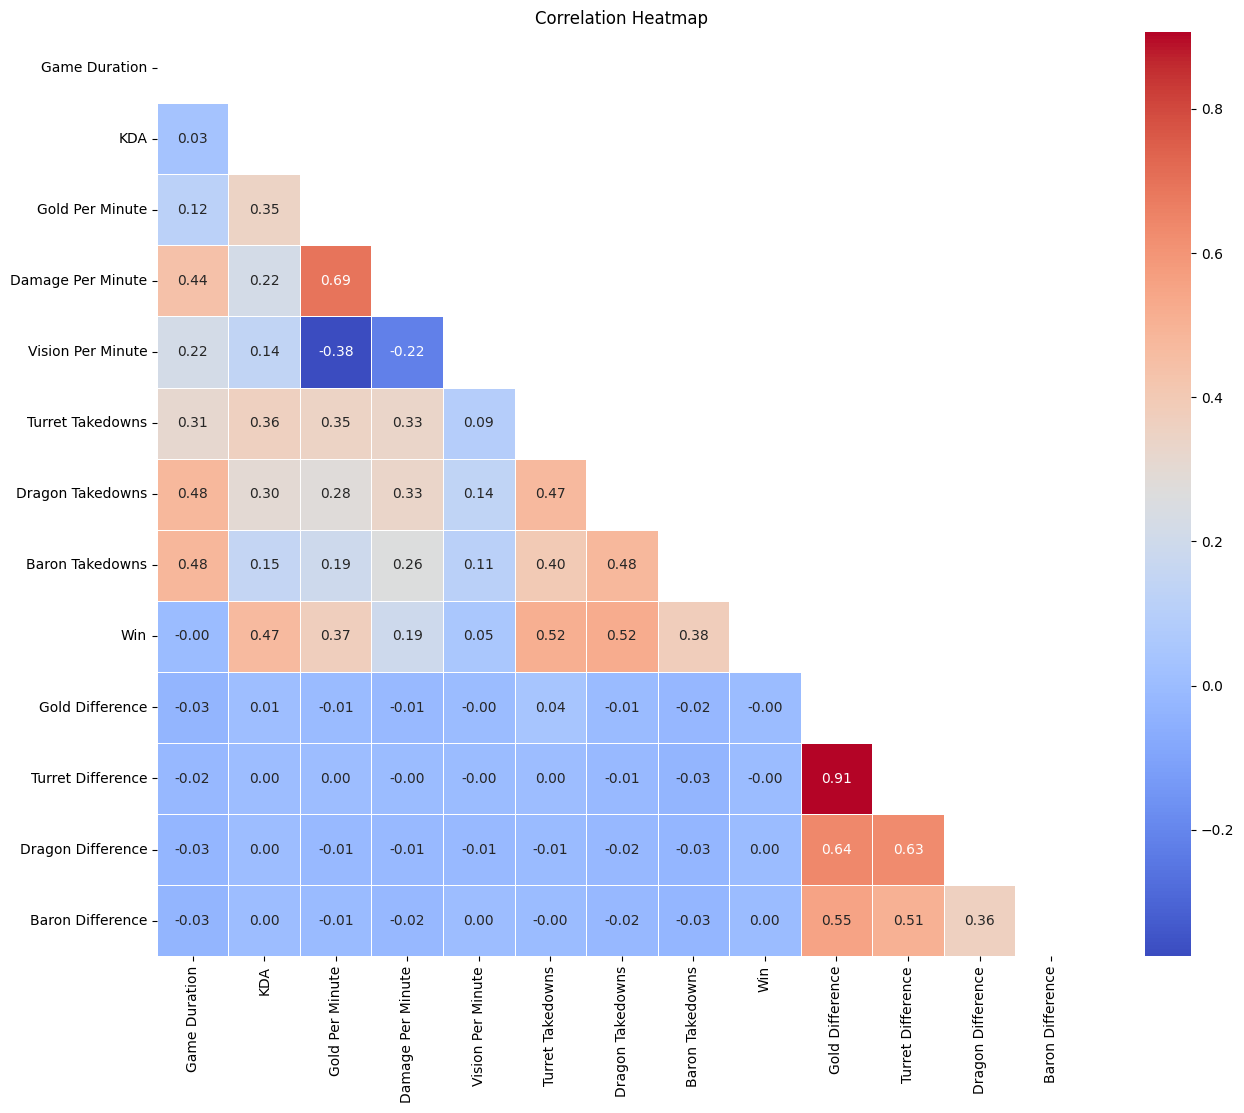


Feature Engineering:
Win Rates by Role:
Role
BOTTOM     0.500271
JUNGLE     0.500320
MIDDLE     0.500320
TOP        0.500467
UTILITY    0.500320
Name: Win, dtype: float64

Preparing data for modeling...
Processed data saved. Total records: 101623


In [13]:
def analyze_and_prepare_data(combined_df=None):
    # Load data if not provided
    if combined_df is None:
        combined_df = pd.read_csv('/content/drive/My Drive/Complete_match_data(solo+pro).csv')

    # Print initial dataset size
    print(f"Initial dataset size: {combined_df.shape}")

    # Remove rows with missing Role values (from arena mode or forfeited games)
    initial_count = len(combined_df)
    combined_df = combined_df.dropna(subset=['Role'])
    removed_count = initial_count - len(combined_df)
    print(f"Removed {removed_count} rows with missing Role values (likely from arena mode or forfeited games)")
    print(f"Remaining dataset size: {combined_df.shape}")

    # Handle remaining missing values
    print("\nRemaining Missing Values:")
    print(combined_df.isnull().sum())

    # Fill missing numerical values with median
    numeric_columns = combined_df.select_dtypes(include=['float64', 'int64']).columns
    for col in numeric_columns:
        combined_df[col] = combined_df[col].fillna(combined_df[col].median())

    # Verify all missing values are handled
    print("\nMissing Values After Handling:")
    print(combined_df.isnull().sum())

    # Display basic information about the cleaned dataset
    print("\nCleaned Dataset Shape:", combined_df.shape)
    print("\nData Types:")
    print(combined_df.dtypes)
    print("\nBasic Statistics:")
    print(combined_df.describe())

    # Exploratory Data Analysis
    # Plot 1: Win ratio by region
    plt.figure(figsize=(15, 8))
    plt.subplot(231)
    win_by_region = combined_df.groupby('Region')['Win'].mean()
    sns.barplot(x=win_by_region.index, y=win_by_region.values)
    plt.title('Win Ratio by Region')
    plt.ylim(0, 1)

    # Plot 2: Win ratio by role
    plt.subplot(232)
    win_by_role = combined_df.groupby('Role')['Win'].mean()
    sns.barplot(x=win_by_role.index, y=win_by_role.values)
    plt.title('Win Ratio by Role')
    plt.ylim(0, 1)

    # Plot 3: Game Duration vs Win
    plt.subplot(233)
    sns.boxplot(x='Win', y='Game Duration', data=combined_df)
    plt.title('Game Duration vs Win')

    # Plot 4: KDA vs Win
    plt.subplot(234)
    sns.boxplot(x='Win', y='KDA', data=combined_df)
    plt.title('KDA vs Win')

    # Plot 5: Gold Per Minute vs Win
    plt.subplot(235)
    sns.boxplot(x='Win', y='Gold Per Minute', data=combined_df)
    plt.title('Gold Per Minute vs Win')

    # Plot 6: Baron control vs Win
    plt.subplot(236)
    sns.boxplot(x='Win', y='Baron Takedowns', data=combined_df)
    plt.title('Baron Takedowns vs Win')

    plt.tight_layout()
    plt.savefig('win_factors_analysis.png', dpi=300)
    plt.show()

    # Correlation heatmap
    plt.figure(figsize=(15, 12))
    numerical_cols = combined_df.select_dtypes(include=['float64', 'int64']).columns
    correlation = combined_df[numerical_cols].corr()
    mask = np.triu(correlation)
    sns.heatmap(correlation, annot=True, cmap='coolwarm', linewidths=0.5, fmt=".2f", mask=mask)
    plt.title('Correlation Heatmap')
    plt.savefig('correlation_matrix.png', dpi=300)
    plt.show()

    # Feature engineering
    print("\nFeature Engineering:")
    # Calculate win rate by role
    role_win_rates = combined_df.groupby('Role')['Win'].mean()
    print("Win Rates by Role:")
    print(role_win_rates)

    # Calculate if gold per minute is above average
    avg_gpm = combined_df['Gold Per Minute'].mean()
    combined_df['High_GPM'] = (combined_df['Gold Per Minute'] > avg_gpm).astype(int)

    # Calculate if KDA is above average
    avg_kda = combined_df['KDA'].mean()
    combined_df['High_KDA'] = (combined_df['KDA'] > avg_kda).astype(int)

    # Calculate if vision control is above average
    avg_vision = combined_df['Vision Per Minute'].mean()
    combined_df['High_Vision'] = (combined_df['Vision Per Minute'] > avg_vision).astype(int)

    # Calculate if object control is strong
    combined_df['Strong_Obj_Control'] = ((combined_df['Dragon Takedowns'] >= 2) |
                                        (combined_df['Baron Takedowns'] >= 1)).astype(int)

    # Calculate the total team resource advantage
    combined_df['Resource_Advantage'] = combined_df['Gold Difference'] + \
                                       (combined_df['Turret Difference'] * 500) + \
                                       (combined_df['Dragon Difference'] * 1000) + \
                                       (combined_df['Baron Difference'] * 1500)

    # Create a binary feature for significant resource advantage
    combined_df['Significant_Advantage'] = (combined_df['Resource_Advantage'] > 0).astype(int)

    # Prepare data for modeling
    print("\nPreparing data for modeling...")

    # Get dummies for categorical features
    cat_features = ['Region', 'Role']
    combined_df_encoded = pd.get_dummies(combined_df, columns=cat_features, drop_first=True)

    # Save processed data
    combined_df_encoded.to_csv('/content/drive/My Drive/processed_match_data.csv', index=False)
    print(f"Processed data saved. Total records: {len(combined_df_encoded)}")

    return combined_df_encoded
processed_df = analyze_and_prepare_data()

# Prepare data for model training

In [29]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

=== League of Legends Win Prediction Project ===

Phase 1: Loading and Processing Data
Loading pre-collected data...
Loaded 102124 records from existing data files.

Phase 2: Data Analysis and Feature Engineering
Initial dataset size: (102124, 18)
Removed 501 rows with missing Role values (likely from arena mode or forfeited games)
Remaining dataset size: (101623, 18)

Remaining Missing Values:
Match ID                0
Region                  0
Game Duration           0
Role                    0
KDA                     0
Gold Per Minute         0
Damage Per Minute       0
Vision Per Minute       0
Turret Takedowns        0
Dragon Takedowns        0
Baron Takedowns         0
Win                     0
Items Bought            0
Legendary Items         0
Gold Difference         0
Turret Difference    1990
Dragon Difference    1990
Baron Difference        0
dtype: int64

Missing Values After Handling:
Match ID             0
Region               0
Game Duration        0
Role                

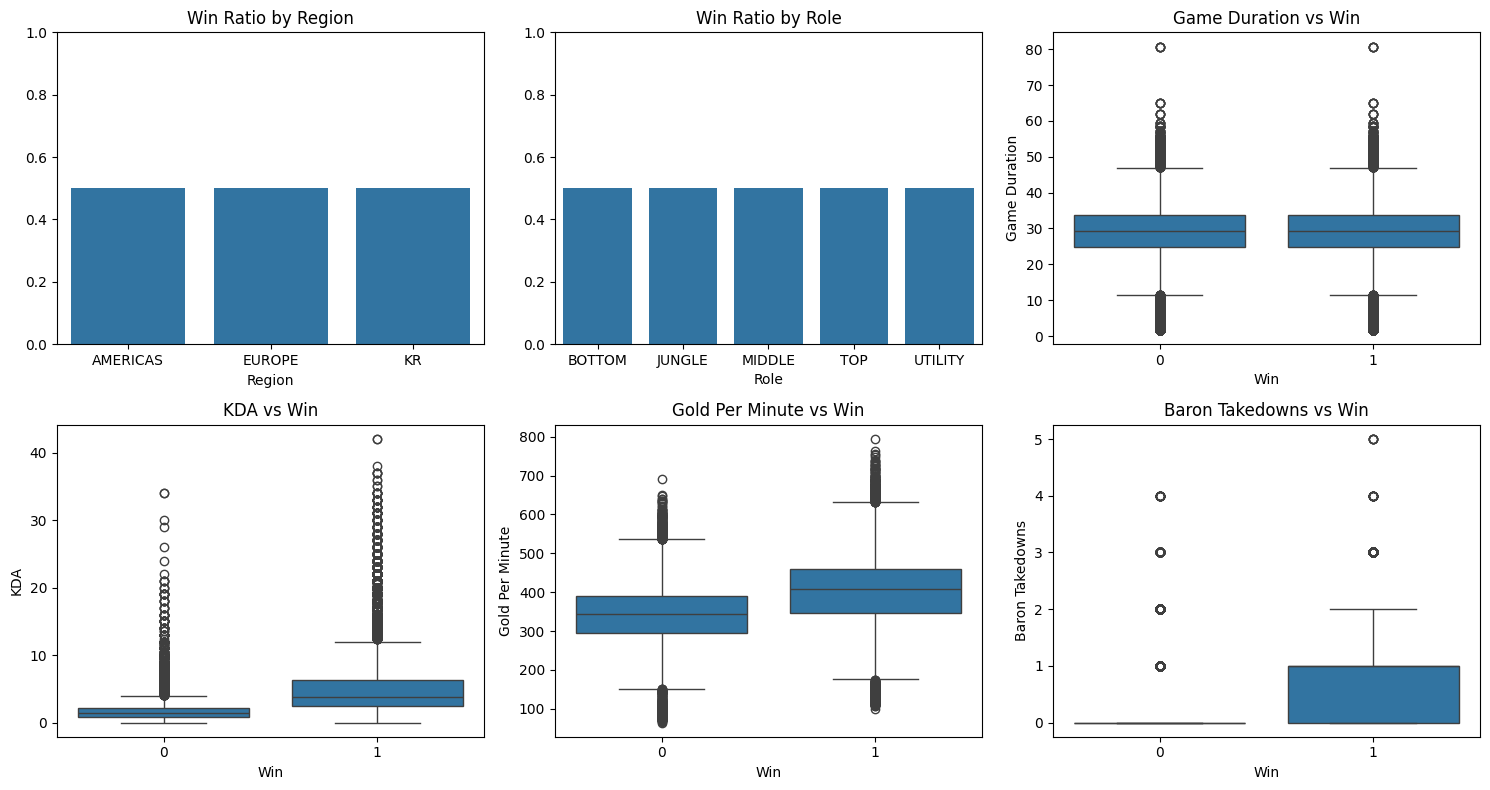

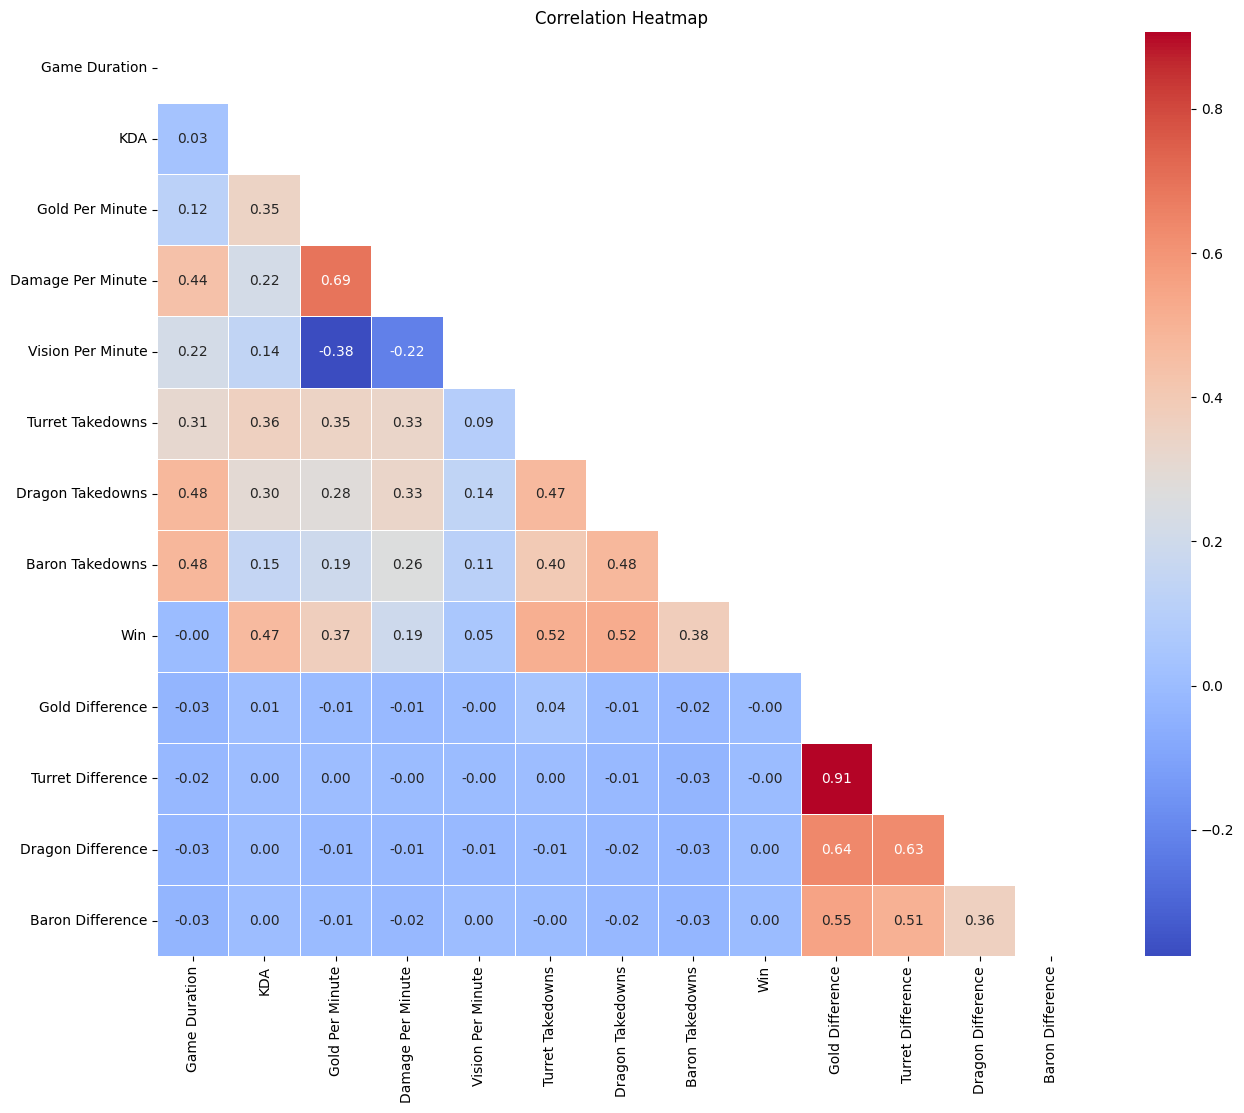


Feature Engineering:
Win Rates by Role:
Role
BOTTOM     0.500271
JUNGLE     0.500320
MIDDLE     0.500320
TOP        0.500467
UTILITY    0.500320
Name: Win, dtype: float64

Preparing data for modeling...
Processed data saved. Total records: 101623

Phase 3: Model Training and Evaluation
Training Logistic Regression...
Logistic Regression - Accuracy: 0.8885
              precision    recall  f1-score   support

           0       0.88      0.90      0.89     12654
           1       0.89      0.88      0.89     12752

    accuracy                           0.89     25406
   macro avg       0.89      0.89      0.89     25406
weighted avg       0.89      0.89      0.89     25406



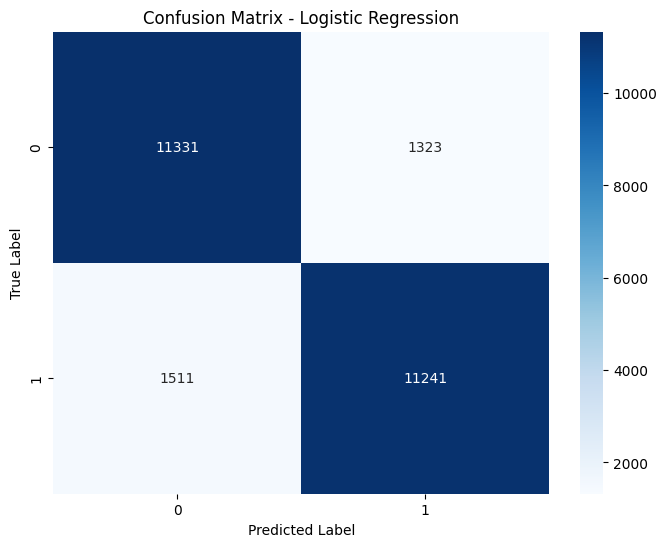

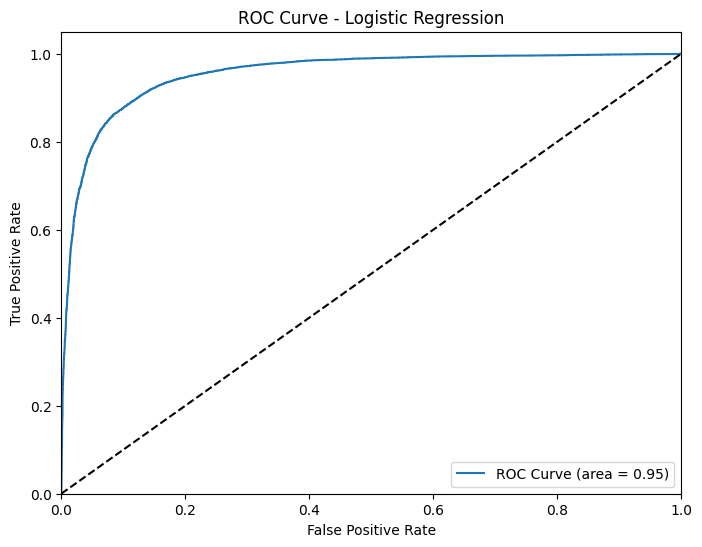

Training Random Forest...
Random Forest - Accuracy: 0.9526
              precision    recall  f1-score   support

           0       0.95      0.95      0.95     12654
           1       0.95      0.95      0.95     12752

    accuracy                           0.95     25406
   macro avg       0.95      0.95      0.95     25406
weighted avg       0.95      0.95      0.95     25406



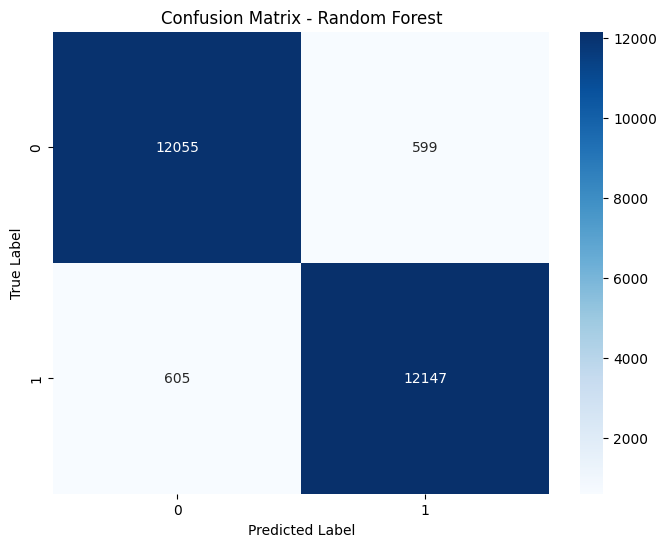

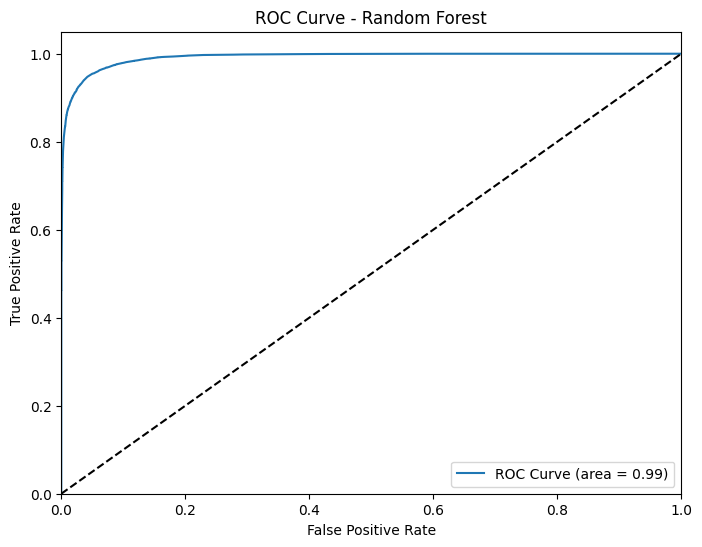

Training Gradient Boosting...
Gradient Boosting - Accuracy: 0.9139
              precision    recall  f1-score   support

           0       0.91      0.92      0.91     12654
           1       0.92      0.91      0.91     12752

    accuracy                           0.91     25406
   macro avg       0.91      0.91      0.91     25406
weighted avg       0.91      0.91      0.91     25406



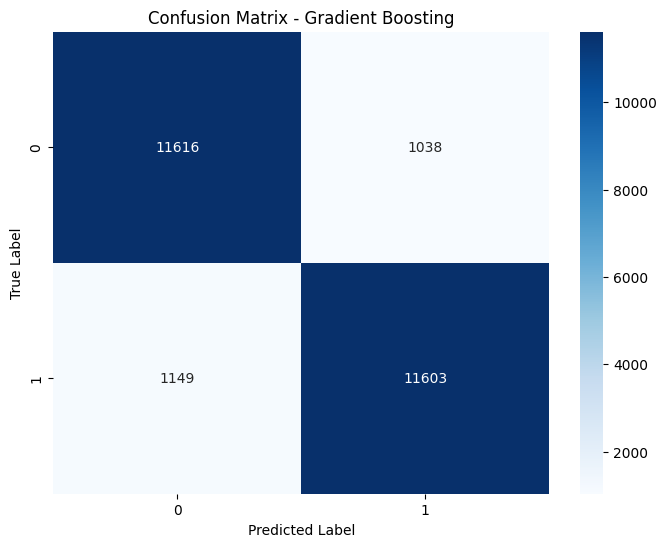

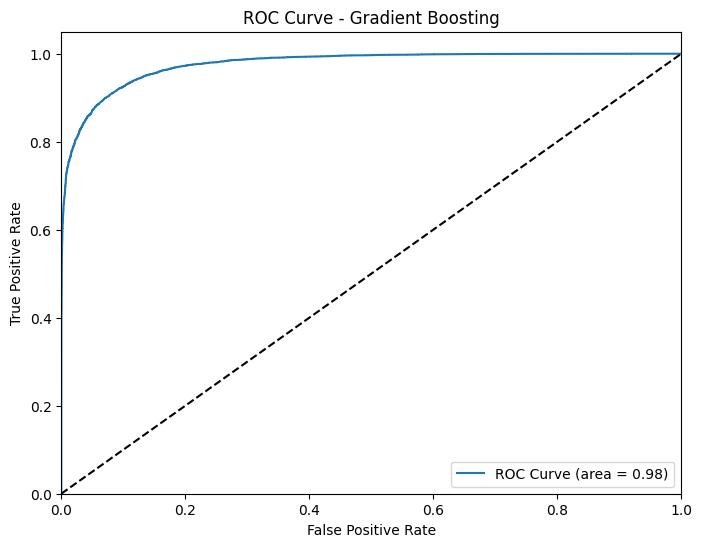

Training XGBoost...
XGBoost - Accuracy: 0.9591
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     12654
           1       0.96      0.96      0.96     12752

    accuracy                           0.96     25406
   macro avg       0.96      0.96      0.96     25406
weighted avg       0.96      0.96      0.96     25406



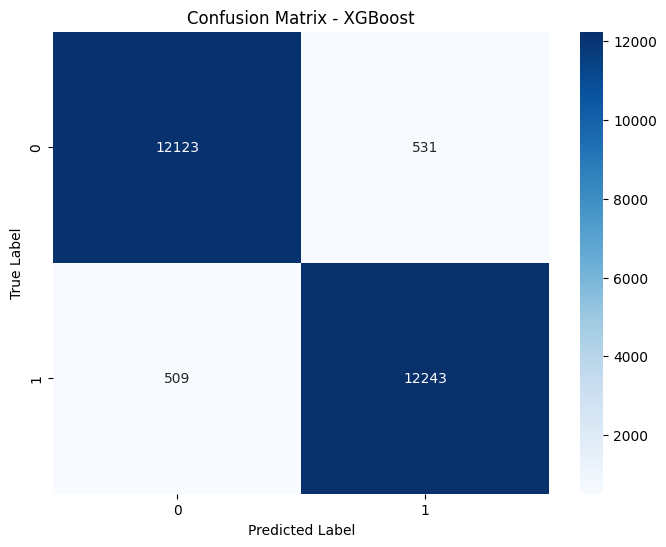

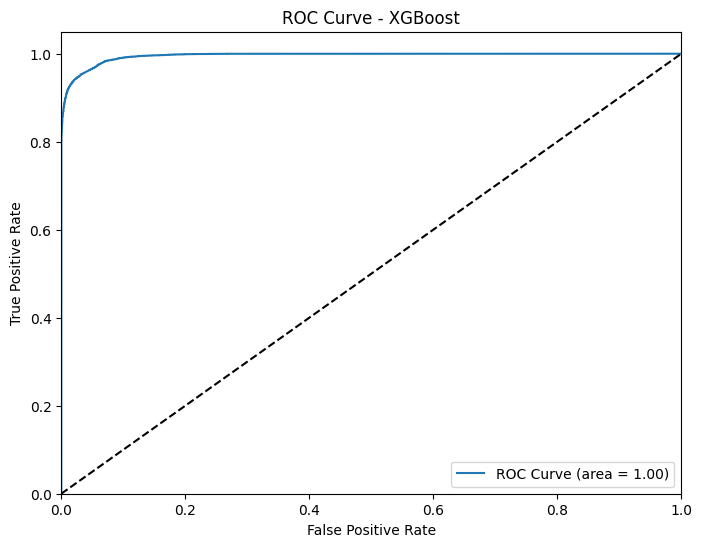

Training SVM...


In [ ]:
def lol_win_prediction_workflow():
    """
    End-to-end workflow for League of Legends win prediction project
    """
    print("=== League of Legends Win Prediction Project ===")
    print("\nPhase 1: Loading and Processing Data")

    # Option 1: Load pre-collected data
    try:
        print("Loading pre-collected data...")
        combined_df = pd.read_csv('/content/drive/My Drive/Complete_match_data(solo+pro).csv')
        print(f"Loaded {len(combined_df)} records from existing data files.")
    except:
        print("Pre-collected data not found. Starting data collection...")
        # Option 2: Collect new data (this would take a long time)
        solo_df = collect_soloq_data()
        combined_df = combine_soloq_pro_data(solo_df)

    print("\nPhase 2: Data Analysis and Feature Engineering")
    # Process data and remove irrelevant entries
    processed_df = analyze_and_prepare_data(combined_df)

    print("\nPhase 3: Model Training and Evaluation")
    # Train and evaluate multiple machine learning models
    best_model = train_evaluate_models(processed_df)

    print("\nPhase 4: Develop Win Prediction Application")
    # Create a Gradio interface for real-time win prediction
    create_win_prediction_app(best_model)

    print("\nProject workflow completed successfully!")

    return best_model, processed_df

# Function to complete training and evaluation of models
def train_evaluate_models(processed_df):
    # Prepare features and target
    drop_columns = ['Match ID', 'Items Bought', 'Legendary Items']
    drop_columns = [col for col in drop_columns if col in processed_df.columns]

    X = processed_df.drop(['Win'] + drop_columns, axis=1)
    y = processed_df['Win']

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

    # Define features by type
    numerical_features = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
    categorical_features = X.select_dtypes(include=['object']).columns.tolist()

    # Define preprocessing pipeline
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler())
            ]), numerical_features),
            ('cat', Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('onehot', OneHotEncoder(handle_unknown='ignore'))
            ]), categorical_features) if categorical_features else ('cat', 'passthrough', [])
        ])

    # Define models to evaluate
    models = {
        'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
        'Random Forest': RandomForestClassifier(random_state=42),
        'Gradient Boosting': GradientBoostingClassifier(random_state=42),
        'XGBoost': XGBClassifier(random_state=42),
        'SVM': SVC(probability=True, random_state=42),
        'KNN': KNeighborsClassifier(),
        'Decision Tree': DecisionTreeClassifier(random_state=42),
        'AdaBoost': AdaBoostClassifier(random_state=42),
        'Neural Network': MLPClassifier(max_iter=1000, random_state=42)
    }

    # Train and evaluate models
    results = {}
    for name, model in models.items():
        print(f"Training {name}...")
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', model)
        ])

        # Train the model
        pipeline.fit(X_train, y_train)

        # Evaluate the model
        y_pred = pipeline.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        results[name] = accuracy

        print(f"{name} - Accuracy: {accuracy:.4f}")
        print(classification_report(y_test, y_pred))

        # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix - {name}')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.savefig(f'confusion_matrix_{name.replace(" ", "_").lower()}.png', dpi=300)
        plt.show()

        # ROC Curve (for models that support predict_proba)
        try:
            y_prob = pipeline.predict_proba(X_test)[:, 1]
            fpr, tpr, _ = roc_curve(y_test, y_prob)
            roc_auc = auc(fpr, tpr)

            plt.figure(figsize=(8, 6))
            plt.plot(fpr, tpr, label=f'ROC Curve (area = {roc_auc:.2f})')
            plt.plot([0, 1], [0, 1], 'k--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'ROC Curve - {name}')
            plt.legend(loc="lower right")
            plt.savefig(f'roc_curve_{name.replace(" ", "_").lower()}.png', dpi=300)
            plt.show()
        except:
            print(f"ROC curve cannot be computed for {name}")

    # Compare model performance
    plt.figure(figsize=(12, 6))
    models_df = pd.DataFrame({'Model': list(results.keys()), 'Accuracy': list(results.values())})
    models_df = models_df.sort_values('Accuracy', ascending=False)
    sns.barplot(x='Accuracy', y='Model', data=models_df)
    plt.title('Model Comparison')
    plt.xlim(0, 1)
    plt.tight_layout()
    plt.savefig('model_comparison.png', dpi=300)
    plt.show()

    # Select the best model
    best_model_name = models_df.iloc[0]['Model']
    print(f"Best model: {best_model_name} with accuracy {models_df.iloc[0]['Accuracy']:.4f}")

    # Hyperparameter tuning for the best model
    print(f"\nPerforming hyperparameter tuning for {best_model_name}...")

    # Define parameter grid based on the best model
    if best_model_name == 'Logistic Regression':
        param_grid = {
            'classifier__C': [0.01, 0.1, 1, 10, 100],
            'classifier__solver': ['liblinear', 'lbfgs'],
            'classifier__penalty': ['l1', 'l2']
        }
    elif best_model_name == 'Random Forest':
        param_grid = {
            'classifier__n_estimators': [50, 100, 200],
            'classifier__max_depth': [None, 10, 20, 30],
            'classifier__min_samples_split': [2, 5, 10],
            'classifier__min_samples_leaf': [1, 2, 4]
        }
    elif best_model_name == 'Gradient Boosting':
        param_grid = {
            'classifier__n_estimators': [50, 100, 200],
            'classifier__learning_rate': [0.01, 0.1, 0.2],
            'classifier__max_depth': [3, 5, 7]
        }
    elif best_model_name == 'XGBoost':
        param_grid = {
            'classifier__n_estimators': [50, 100, 200],
            'classifier__learning_rate': [0.01, 0.1, 0.2],
            'classifier__max_depth': [3, 5, 7]
        }
    elif best_model_name == 'SVM':
        param_grid = {
            'classifier__C': [0.1, 1, 10],
            'classifier__kernel': ['linear', 'rbf'],
            'classifier__gamma': ['scale', 'auto', 0.1, 1]
        }
    elif best_model_name == 'KNN':
        param_grid = {
            'classifier__n_neighbors': [3, 5, 7, 9],
            'classifier__weights': ['uniform', 'distance'],
            'classifier__p': [1, 2]
        }
    elif best_model_name == 'Decision Tree':
        param_grid = {
            'classifier__max_depth': [None, 10, 20, 30],
            'classifier__min_samples_split': [2, 5, 10],
            'classifier__min_samples_leaf': [1, 2, 4]
        }
    elif best_model_name == 'AdaBoost':
        param_grid = {
            'classifier__n_estimators': [50, 100, 200],
            'classifier__learning_rate': [0.01, 0.1, 1]
        }
    elif best_model_name == 'Neural Network':
        param_grid = {
            'classifier__hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
            'classifier__activation': ['relu', 'tanh'],
            'classifier__alpha': [0.0001, 0.001, 0.01],
            'classifier__learning_rate': ['constant', 'adaptive']
        }

    # Create a pipeline with the best model
    best_model = models[best_model_name]
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', best_model)
    ])

    # Perform grid search
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Print the best parameters
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")

    # Evaluate the tuned model
    best_pipeline = grid_search.best_estimator_
    y_pred = best_pipeline.predict(X_test)
    tuned_accuracy = accuracy_score(y_test, y_pred)
    print(f"Tuned model accuracy on test data: {tuned_accuracy:.4f}")
    print(classification_report(y_test, y_pred))

    # Feature importance analysis for the tuned model
    if hasattr(best_pipeline.named_steps['classifier'], 'feature_importances_'):
        # Get the feature names after preprocessing
        categorical_encoder = preprocessor.transformers_[1][1].named_steps['onehot']
        if categorical_features:
            cat_feature_names = categorical_encoder.get_feature_names_out(categorical_features)
            all_feature_names = numerical_features + list(cat_feature_names)
        else:
            all_feature_names = numerical_features

        # Get feature importances
        feature_importances = best_pipeline.named_steps['classifier'].feature_importances_

        # Create DataFrame for easier visualization
        feature_importance_df = pd.DataFrame({
            'Feature': all_feature_names,
            'Importance': feature_importances
        })
        feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

        # Plot top 20 features
        plt.figure(figsize=(12, 8))
        top_features = feature_importance_df.head(20)
        sns.barplot(x='Importance', y='Feature', data=top_features)
        plt.title(f'Top 20 Feature Importances - {best_model_name}')
        plt.tight_layout()
        plt.savefig('top_features_importance.png', dpi=300)
        plt.show()

        print("\nTop 10 Most Important Features:")
        print(feature_importance_df.head(10))

    # Save the best model
    joblib.dump(best_pipeline, 'lol_win_prediction_model.pkl')
    print("Best model saved as 'lol_win_prediction_model.pkl'")

    return best_pipeline

lol_win_prediction_workflow()

# Save the best model for future use

In [60]:
class LOLWinPredictor:
    def __init__(self, api_key=None, region="euw1", model_path="lol_win_prediction_model.pkl"):
        """
        Initialize the League of Legends win probability predictor.

        Parameters:
        api_key (str): Riot API key. If None, will try to get from environment variable.
        region (str): Game region (e.g., 'euw1', 'na1')
        model_path (str): Path to the trained model
        """
        # Set up API key (from parameter or environment)
        self.api_key = api_key or os.getenv("RIOT_API_KEY")
        if not self.api_key:
            raise ValueError("API key must be provided or set as RIOT_API_KEY environment variable")

        # Set up regions and endpoints
        self.region = region
        self.region_host = f"{region}.api.riotgames.com"
        self.routing_host = self._get_routing_host(region)

        # Load the trained model
        try:
            self.model = joblib.load(model_path)
            print(f"Model loaded successfully from {model_path}")
        except Exception as e:
            raise ValueError(f"Failed to load model from {model_path}: {e}")

        # Track game state
        self.current_game_id = None
        self.game_start_time = None
        self.player_data = {}
        self.team_data = {100: {}, 200: {}}  # Blue team (100) and Red team (200)
        self.required_features = self._get_model_features()

    def _get_routing_host(self, region):
        """Map regional API endpoint to routing value"""
        routing_map = {
            'euw1': 'europe',
            'na1': 'americas',
            'kr': 'asia',
            # Add other regions as needed
        }
        return f"{routing_map.get(region, 'europe')}.api.riotgames.com"

    def _get_model_features(self):
        """Get the features required by the model"""
        # This should match the columns used during training
        # You may need to adjust this based on your actual model
        return [
            'KDA', 'Gold_Per_Minute', 'Damage_Per_Minute', 'Vision_Per_Minute',
            'Turret_Takedowns', 'Dragon_Takedowns', 'Baron_Takedowns',
            'Gold_Difference', 'Turret_Difference', 'Dragon_Difference', 'Baron_Difference'
        ]

    def _make_request(self, endpoint, host=None):
        """Make a request to the Riot API"""
        if host is None:
            host = self.region_host

        url = f"https://{host}{endpoint}?api_key={self.api_key}"
        response = requests.get(url)

        if response.status_code == 200:
            return response.json()
        elif response.status_code == 404:
            return None
        else:
            print(f"Error {response.status_code} when calling {url}: {response.text}")
            return None

    def get_account_by_puuid(self, puuid):
        """Get account information using PUUID"""
        endpoint = f"/riot/account/v1/accounts/by-puuid/{puuid}"
        return self._make_request(endpoint, self.routing_host)

    def get_summoner_by_puuid(self, puuid):
        """Get summoner information using PUUID"""
        endpoint = f"/lol/summoner/v4/summoners/by-puuid/{puuid}"
        return self._make_request(endpoint)

    def get_active_game(self, puuid):
        """Get active game information for a summoner"""
        # First get summoner info
        summoner = self.get_summoner_by_puuid(puuid)
        if not summoner:
            print(f"Summoner not found for PUUID: {puuid}")
            return None

        # Then get active game
        endpoint = f"/lol/spectator/v5/active-games/by-summoner/{[puuid]}"
        game_data = self._make_request(endpoint)

        if game_data:
            self.current_game_id = game_data['gameId']
            self.game_start_time = game_data['gameStartTime'] / 1000  # Convert to seconds
            print(f"Found active game: {self.current_game_id}")

            # Initialize player and team data
            self._initialize_game_data(game_data)

        return game_data

    def _initialize_game_data(self, game_data):
        """Initialize game data structures with starting information"""
        # Reset data structures
        self.player_data = {}
        self.team_data = {100: {}, 200: {}}

        # Initialize team data
        for team_id in [100, 200]:  # Blue and Red teams
            self.team_data[team_id] = {
                'Turret_Takedowns': 0,
                'Dragon_Takedowns': 0,
                'Baron_Takedowns': 0,
                'Total_Gold': 0
            }

        # Initialize player data
        for participant in game_data.get('participants', []):
            champion_id = participant.get('championId', 0)
            summoner_id = participant.get('summonerId', '')
            team_id = participant.get('teamId', 100)

            self.player_data[summoner_id] = {
                'championId': champion_id,
                'teamId': team_id,
                'role': self._infer_role(participant),
                'KDA': 0,
                'Gold_Per_Minute': 0,
                'Damage_Per_Minute': 0,
                'Vision_Per_Minute': 0,
                'Turret_Takedowns': 0,
                'Dragon_Takedowns': 0,
                'Baron_Takedowns': 0,
                'Items_Bought': [],
                'Legendary_Items': 0,
                'Total_Gold': 0,
                'Total_Damage': 0,
                'Vision_Score': 0,
                'Kills': 0,
                'Deaths': 0,
                'Assists': 0,
                'Gold_Difference': 0,
                'Turret_Difference': 0,
                'Dragon_Difference': 0,
                'Baron_Difference': 0
            }

    def _infer_role(self, participant):
        """Infer player role based on champion, spells, and lane position"""
        # Simple placeholder - in a real implementation you'd use more sophisticated logic
        # based on champion, summoner spells, starting items, etc.
        champion_id = participant.get('championId', 0)

        # This is a very simplified mapping - you'd want a more complete one
        support_champions = [12, 16, 22, 25, 26, 27, 40, 43, 44, 53, 89, 99, 111, 117, 147, 161,201, 235, 267, 350, 412, 432, 497, 518, 526, 555],
        adc_champions = [15, 22, 29, 42, 51, 67, 81, 96, 110, 115, 119, 202, 222, 236, 145, 360, 429, 498, 523],
        mid_champions = [1, 3, 4, 7, 8, 13, 18, 34, 38, 45, 50, 55, 61, 69, 81, 84, 90, 91 , 101, 103, 105, 112, 126, 127, 131, 134, 136, 142, 157, 163, 166, 238, 245, 246, 268, 517, 777],
        jungle_champions = [5, 9, 11, 19, 20, 21, 28, 29, 30, 33, 35, 53, 56, 57, 59, 60, 62, 63, 64, 72, 76, 102, 104, 106, 107, 113, 120, 121, 141, 143, 154, 203, 234, 254, 421, 427, 876],
        top_champions = [2, 6, 10, 14, 17, 23, 24, 27, 31, 36, 39, 37, 41, 48, 54, 58, 68, 74, 75, 77, 78, 79, 80, 82, 83, 85, 86, 92, 98, 114, 122, 133, 150, 164, 223, 240, 256, 420, 516, 875, 887]

        if champion_id in support_champions:
            return "SUPPORT"
        elif champion_id in adc_champions:
            return "ADC"
        elif champion_id in mid_champions:
            return "MID"
        elif champion_id in jungle_champions:
            return "JUNGLE"
        elif champion_id in top_champions:
            return "TOP"
        else:
            # Default fallback
            if 'lane' in participant:
                return participant['lane']
            else:
                return "UNKNOWN"

    def _calculate_game_duration_minutes(self):
        """Calculate the current game duration in minutes"""
        if not self.game_start_time:
            return 0

        current_time = time.time()
        duration_seconds = current_time - self.game_start_time
        return duration_seconds / 60

    def _update_game_stats(self, live_game_stats):
        """Update game statistics based on live data"""
        # This is a placeholder for where you'd process live game statistics
        # In a real implementation, you'd parse events from the Riot API

        game_duration = self._calculate_game_duration_minutes()
        if game_duration <= 0:
            return

        # Reset team totals before accumulating
        for team_id in self.team_data:
            self.team_data[team_id]['Total_Gold'] = 0
            self.team_data[team_id]['Turret_Takedowns'] = 0
            self.team_data[team_id]['Dragon_Takedowns'] = 0
            self.team_data[team_id]['Baron_Takedowns'] = 0

        # Process the stats for each player
        for player_id, stats in live_game_stats.items():
            if player_id in self.player_data:
                player = self.player_data[player_id]
                team_id = player['teamId']

                # Update player stats
                player['Total_Gold'] = stats.get('totalGold', 0)
                player['Total_Damage'] = stats.get('totalDamageDealtToChampions', 0)
                player['Vision_Score'] = stats.get('visionScore', 0)
                player['Kills'] = stats.get('kills', 0)
                player['Deaths'] = stats.get('deaths', 0)
                player['Assists'] = stats.get('assists', 0)
                player['Turret_Takedowns'] = stats.get('turretKills', 0)
                player['Dragon_Takedowns'] = stats.get('dragonKills', 0)
                player['Baron_Takedowns'] = stats.get('baronKills', 0)

                # Calculate per-minute stats
                player['Gold_Per_Minute'] = player['Total_Gold'] / max(game_duration, 1)
                player['Damage_Per_Minute'] = player['Total_Damage'] / max(game_duration, 1)
                player['Vision_Per_Minute'] = player['Vision_Score'] / max(game_duration, 1)

                # Calculate KDA
                if player['Deaths'] == 0:
                    player['KDA'] = (player['Kills'] + player['Assists']) / 1  # Avoid division by zero
                else:
                    player['KDA'] = (player['Kills'] + player['Assists']) / player['Deaths']

                # Update team totals
                self.team_data[team_id]['Total_Gold'] += player['Total_Gold']
                self.team_data[team_id]['Turret_Takedowns'] += player['Turret_Takedowns']
                self.team_data[team_id]['Dragon_Takedowns'] += player['Dragon_Takedowns']
                self.team_data[team_id]['Baron_Takedowns'] += player['Baron_Takedowns']

    def _calculate_team_differences(self):
        """Calculate differences between teams"""
        blue_team = self.team_data.get(100, {})
        red_team = self.team_data.get(200, {})

        # Ensure all required fields exist in team data
        for field in ['Total_Gold', 'Turret_Takedowns', 'Dragon_Takedowns', 'Baron_Takedowns']:
            if field not in blue_team:
                blue_team[field] = 0
            if field not in red_team:
                red_team[field] = 0

        # Calculate differences for blue team
        gold_diff = blue_team['Total_Gold'] - red_team['Total_Gold']
        turret_diff = blue_team['Turret_Takedowns'] - red_team['Turret_Takedowns']
        dragon_diff = blue_team['Dragon_Takedowns'] - red_team['Dragon_Takedowns']
        baron_diff = blue_team['Baron_Takedowns'] - red_team['Baron_Takedowns']

        # Update player differences based on team
        for player_id, player in self.player_data.items():
            if player['teamId'] == 100:  # Blue team
                player['Gold_Difference'] = gold_diff
                player['Turret_Difference'] = turret_diff
                player['Dragon_Difference'] = dragon_diff
                player['Baron_Difference'] = baron_diff
            else:  # Red team
                player['Gold_Difference'] = -gold_diff
                player['Turret_Difference'] = -turret_diff
                player['Dragon_Difference'] = -dragon_diff
                player['Baron_Difference'] = -baron_diff

    def _get_model_features(self):
      """Get the features required by the model"""
    # Using spaces instead of underscores to match the model's expected column names
      return [
        'KDA', 'Gold Per Minute', 'Damage Per Minute', 'Vision Per Minute',
        'Turret Takedowns', 'Dragon Takedowns', 'Baron Takedowns',
        'Gold Difference', 'Turret Difference', 'Dragon Difference', 'Baron Difference'
    ]

    def _prepare_prediction_data(self):
        """Prepare data for win probability prediction"""
        prediction_data = []

        # Map from snake_case to space-separated feature names
        feature_map = {
            'KDA': 'KDA',
            'Gold_Per_Minute': 'Gold Per Minute',
            'Damage_Per_Minute': 'Damage Per Minute',
            'Vision_Per_Minute': 'Vision Per Minute',
            'Turret_Takedowns': 'Turret Takedowns',
            'Dragon_Takedowns': 'Dragon Takedowns',
            'Baron_Takedowns': 'Baron Takedowns',
            'Gold_Difference': 'Gold Difference',
            'Turret_Difference': 'Turret Difference',
            'Dragon_Difference': 'Dragon Difference',
            'Baron_Difference': 'Baron Difference'
        }

        for player_id, player in self.player_data.items():
            # Create a dictionary with the model's expected column names
            player_features = {}

            # Convert from snake_case to space-separated feature names
            for snake_case, space_case in feature_map.items():
                player_features[space_case] = player.get(snake_case, 0)

            # Add metadata (also using the same naming convention as the model)
            player_features['Match ID'] = self.current_game_id
            player_features['Region'] = self.region
            player_features['Game Duration'] = self._calculate_game_duration_minutes()
            player_features['Role'] = player['role']

            prediction_data.append(player_features)

        return pd.DataFrame(prediction_data)

    def predict_win_probability(self):
      """Predict win probability for current game state"""
      if not self.current_game_id:
        print("No active game found")
        return None

      # Calculate team differences
      self._calculate_team_differences()

      # Prepare prediction data
      prediction_data = self._prepare_prediction_data()
      if prediction_data.empty:

        print("No data available for prediction")
        return None

      # Make prediction using the model
      try:
        # Get the full list of features the model expects
        # This includes both the main features and the metadata
        all_expected_columns = self.required_features + ['Game Duration', 'Role', 'Region']

        # Ensure all required columns are present
        for col in all_expected_columns:
            if col not in prediction_data.columns:
                print(f"Adding missing column: {col}")
                prediction_data[col] = 0

        # Select all required features in correct order
        prediction_features = prediction_data[all_expected_columns]

        # Predict win probability
        win_probs = self.model.predict_proba(prediction_features)[:, 1]

        # Calculate team win probabilities (average of players in team)
        team_probs = {100: [], 200: []}

        for i, (player_id, player) in enumerate(self.player_data.items()):

          team_id = player['teamId']
          if i < len(win_probs):
              # Ensure we don't exceed win_probs length
            team_probs[team_id].append(win_probs[i])

        # Average probabilities by team (with safe defaults)
        blue_prob = np.mean(team_probs.get(100, [0.5])) * 100
        red_prob = np.mean(team_probs.get(200, [0.5])) * 100


        return {
            'game_id': self.current_game_id,
            'game_time_minutes': self._calculate_game_duration_minutes(),
            'blue_team_win_probability': blue_prob,
            'red_team_win_probability': red_prob,
            'timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        }

      except Exception as e:
        print(f"Error predicting win probability: {e}")
        import traceback
        traceback.print_exc()
        return None

    def simulate_live_stats(self):
        """
        Simulate live game statistics for testing purposes.
        In a real implementation, you would fetch this data from the Riot API.
        """
        game_time = self._calculate_game_duration_minutes()

        # Simulated game progression
        stats = {}
        for player_id, player in self.player_data.items():
            team_factor = 1.1 if player['teamId'] == 100 else 0.9  # Blue team slight advantage

            # Simulate stats that grow over time
            stats[player_id] = {
                'totalGold': int(500 + (game_time * 350 * team_factor)),
                'totalDamageDealtToChampions': int(500 + (game_time * 600 * team_factor)),
                'visionScore': int(2 + (game_time * 1.2 * team_factor)),
                'kills': int(game_time / 3 * team_factor),
                'deaths': int(game_time / 4 / team_factor),
                'assists': int(game_time / 2 * team_factor),
                'turretKills': int(game_time / 10 * team_factor),
                'dragonKills': int(game_time / 15 * team_factor),
                'baronKills': int(game_time / 30 * team_factor)
            }

        return stats

    def monitor_game(self, puuid, interval=30, duration=None, debug=False):
        """
        Monitor a live game and periodically predict win probability.

        Parameters:
        puuid (str): PUUID of the player to monitor
        interval (int): How often to update predictions (in seconds)
        duration (int): How long to monitor (in seconds), None for indefinite
        debug (bool): Enable debug mode with more verbose output
        """
        # Find the active game
        game = self.get_active_game(puuid)
        if not game:
            print("No active game found for this player")
            return

        print(f"Monitoring game {self.current_game_id} for player with PUUID: {puuid}")
        print(f"Game started at: {datetime.fromtimestamp(self.game_start_time).strftime('%Y-%m-%d %H:%M:%S')}")

        # Debug: Print initial state of data structures
        if debug:
            print("\nInitial Team Data:")
            for team_id, data in self.team_data.items():
                print(f"Team {team_id}: {data}")

            print("\nInitial Player Data:")
            for player_id, data in self.player_data.items():
                print(f"Player {player_id}: {data.keys()}")

        start_time = time.time()
        iteration = 0

        try:
            while True:
                current_time = time.time()
                elapsed = current_time - start_time

                # Check if we've exceeded the monitoring duration
                if duration and elapsed > duration:
                    print(f"Monitoring complete after {duration} seconds")
                    break

                # In a real implementation, you would fetch live game stats here
                # For this example, we'll simulate the stats
                try:
                    live_stats = self.simulate_live_stats()

                    if debug:
                        print(f"\nIteration {iteration + 1} - Generated live stats for {len(live_stats)} players")

                    # Update game statistics
                    self._update_game_stats(live_stats)

                    if debug:
                        print("Game stats updated successfully")
                        print(f"Team Gold - Blue: {self.team_data[100]['Total_Gold']}, Red: {self.team_data[200]['Total_Gold']}")

                    # Predict win probability
                    prediction = self.predict_win_probability()
                    if prediction:
                        iteration += 1
                        print(f"\nUpdate #{iteration} at game time: {prediction['game_time_minutes']:.2f} minutes")
                        print(f"Blue Team Win Probability: {prediction['blue_team_win_probability']:.2f}%")
                        print(f"Red Team Win Probability: {prediction['red_team_win_probability']:.2f}%")

                        # In a real application, you might want to save these predictions
                        # or display them in a UI

                except Exception as e:
                    print(f"Error during update: {e}")
                    if debug:
                        import traceback
                        traceback.print_exc()

                # Wait for the next update
                time.sleep(interval)

        except KeyboardInterrupt:
            print("\nMonitoring stopped by user")
        except Exception as e:
            print(f"Error during monitoring: {e}")
            if debug:
                import traceback
                traceback.print_exc()


# Example usage
if __name__ == "__main__":
    API_KEY = "RGAPI-bc7dd5bf-0df5-42b8-8f15-768708f8e869"
    PUUID = "kF5Mk4ifckw7xOifmjQ-xH0XHkLNArPWR7Y4yPDv7LGVZH96NRq_8cpW1A0RrMad0M4nocEef0xl4A"

    # Create the predictor
    predictor = LOLWinPredictor(api_key=API_KEY)

    # Monitor the game with debug mode enabled
    predictor.monitor_game(PUUID, interval=30, duration=300, debug=True)

Model loaded successfully from lol_win_prediction_model.pkl
Found active game: 7347965870
Monitoring game 7347965870 for player with PUUID: kF5Mk4ifckw7xOifmjQ-xH0XHkLNArPWR7Y4yPDv7LGVZH96NRq_8cpW1A0RrMad0M4nocEef0xl4A
Game started at: 2025-03-25 22:43:37

Initial Team Data:
Team 100: {'Turret_Takedowns': 0, 'Dragon_Takedowns': 0, 'Baron_Takedowns': 0, 'Total_Gold': 0}
Team 200: {'Turret_Takedowns': 0, 'Dragon_Takedowns': 0, 'Baron_Takedowns': 0, 'Total_Gold': 0}

Initial Player Data:
Player jUDzp8AeY53YKMAcKKz_dyE0IHaOSSFiu_xcvlVSGXzLqEHe: dict_keys(['championId', 'teamId', 'role', 'KDA', 'Gold_Per_Minute', 'Damage_Per_Minute', 'Vision_Per_Minute', 'Turret_Takedowns', 'Dragon_Takedowns', 'Baron_Takedowns', 'Items_Bought', 'Legendary_Items', 'Total_Gold', 'Total_Damage', 'Vision_Score', 'Kills', 'Deaths', 'Assists', 'Gold_Difference', 'Turret_Difference', 'Dragon_Difference', 'Baron_Difference'])
Player 6o4Iq87yiPc93Q6QbLdAgi3ICei8eZo0ditEVCa1RkqtzNc: dict_keys(['championId', 'teamId',

got output but graph is not showing and improve by using baron dragon and kda is not correct

In [64]:
import os
import requests
import pandas as pd
import joblib
import time
import gradio as gr
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use('Agg')

class LOLWinPredictor:
    def __init__(self, api_key=None, region="euw1", model_path="lol_win_prediction_model.pkl"):
        self.api_key = api_key or os.getenv("RIOT_API_KEY")
        if not self.api_key:
            raise ValueError("API key required")
        self.region = region
        self.region_host = f"{region}.api.riotgames.com"
        self.routing_host = self._get_routing_host(region)
        try:
            self.model = joblib.load(model_path)
            print(f"Model loaded from {model_path}")
        except Exception as e:
            raise ValueError(f"Failed to load model: {e}")
        self.current_game_id = None
        self.game_start_time = None
        self.player_data = {}
        self.team_data = {100: {}, 200: {}}
        self.required_features = self._get_model_features()
        self.champion_data = self._get_latest_ddragon()
        self.prediction_history = {'timestamps': [], 'game_time': [], 'blue_win_prob': [], 'red_win_prob': []}

    def _get_routing_host(self, region):
        routing_map = {'euw1': 'europe', 'na1': 'americas', 'kr': 'asia'}
        return f"{routing_map.get(region, 'europe')}.api.riotgames.com"

    def _get_model_features(self):
        return [
            'KDA', 'Gold Per Minute', 'Damage Per Minute', 'Vision Per Minute',
            'Turret Takedowns', 'Dragon Takedowns', 'Baron Takedowns',
            'Gold Difference', 'Turret Difference', 'Dragon Difference', 'Baron Difference'
        ]

    def _make_request(self, endpoint, host=None):
        host = host or self.region_host
        url = f"https://{host}{endpoint}?api_key={self.api_key}"
        response = requests.get(url)
        if response.status_code == 200:
            print(f"Success: {url}")
            return response.json()
        else:
            print(f"Failed: {url} - Status {response.status_code}: {response.text}")
            return None

    def _get_latest_ddragon(self):
        try:
            versions_response = requests.get("https://ddragon.leagueoflegends.com/api/versions.json")
            latest_version = versions_response.json()[0]
            ddragon_response = requests.get(f"https://ddragon.leagueoflegends.com/cdn/{latest_version}/data/en_US/champion.json")
            return ddragon_response.json()["data"]
        except Exception as e:
            print(f"Error fetching Data Dragon: {e}")
            return {}

    def _get_champion_by_key(self, key):
        for champion_name, champion_info in self.champion_data.items():
            if str(champion_info["key"]) == str(key):
                return champion_info
        return None

    def get_account_by_riot_id(self, game_name, tag_line):
        endpoint = f"/riot/account/v1/accounts/by-riot-id/{game_name}/{tag_line}"
        return self._make_request(endpoint, self.routing_host)

    def get_summoner_by_puuid(self, puuid):
        endpoint = f"/lol/summoner/v4/summoners/by-puuid/{puuid}"
        summoner = self._make_request(endpoint)
        if summoner:
            print(f"Summoner found: ID={summoner.get('id')}")
        return summoner

    def get_active_game(self, puuid):
        summoner = self.get_summoner_by_puuid(puuid)
        if not summoner:
            print(f"No summoner found for PUUID: {puuid}")
            return None
        summoner_id = summoner.get('id')
        if not summoner_id:
            print("Summoner ID not found in response")
            return None
        endpoint = f"/lol/spectator/v5/active-games/by-summoner/{puuid}"
        game_data = self._make_request(endpoint)
        if game_data:
            self.current_game_id = game_data['gameId']
            self.game_start_time = game_data.get('gameStartTime', 0) / 1000
            if self.game_start_time == 0:
                print("Game start time is 0, game not started yet")
            else:
                print(f"Found active game: {self.current_game_id}, Start Time: {self.game_start_time}")
            self._initialize_game_data(game_data)
            self.prediction_history = {'timestamps': [], 'game_time': [], 'blue_win_prob': [], 'red_win_prob': []}
        else:
            print(f"No active game for summoner ID: {summoner_id}")
        return game_data

    def _initialize_game_data(self, game_data):
        self.player_data = {}
        self.team_data = {100: {'Total_Gold': 0, 'Turret_Takedowns': 0, 'Dragon_Takedowns': 0, 'Baron_Takedowns': 0},
                         200: {'Total_Gold': 0, 'Turret_Takedowns': 0, 'Dragon_Takedowns': 0, 'Baron_Takedowns': 0}}
        for participant in game_data.get('participants', []):
            summoner_id = participant.get('summonerId', '')
            team_id = participant.get('teamId', 100)
            self.player_data[summoner_id] = {
                'championId': participant.get('championId', 0),
                'teamId': team_id,
                'role': self._infer_role(participant),
                'KDA': 0, 'Gold_Per_Minute': 0, 'Damage_Per_Minute': 0, 'Vision_Per_Minute': 0,
                'Turret_Takedowns': 0, 'Dragon_Takedowns': 0, 'Baron_Takedowns': 0,
                'Total_Gold': 0, 'Total_Damage': 0, 'Vision_Score': 0,
                'Kills': 0, 'Deaths': 0, 'Assists': 0,
                'Gold_Difference': 0, 'Turret_Difference': 0, 'Dragon_Difference': 0, 'Baron_Difference': 0
            }
        print(f"Initialized {len(self.player_data)} players")

    def _infer_role(self, participant):
        champion_id = participant.get('championId', 0)
        champion = self._get_champion_by_key(champion_id)
        if not champion:
            return participant.get('lane', 'UNKNOWN')
        tags = champion.get('tags', [])
        tag_to_role = {'Mage': 'MID', 'Marksman': 'ADC', 'Support': 'SUPPORT', 'Fighter': 'TOP', 'Assassin': 'MID', 'Tank': 'TOP'}
        primary_tag = tags[0] if tags else 'Unknown'
        role = tag_to_role.get(primary_tag, 'UNKNOWN')
        if 'lane' in participant and participant['lane'] != '':
            lane = participant['lane'].upper()
            if lane in ['TOP', 'MID', 'BOTTOM', 'JUNGLE']:
                return lane
            elif lane == 'SUPPORT':
                return 'SUPPORT'
        if 'lane' in participant and participant['lane'].upper() == 'BOTTOM':
            return 'SUPPORT' if 'Support' in tags else 'ADC'
        spells = [participant.get('spell1Id'), participant.get('spell2Id')]
        smite_ids = [11]
        if any(spell in smite_ids for spell in spells if spell):
            return 'JUNGLE'
        return role

    def _calculate_game_duration_minutes(self):
        if not self.game_start_time or self.game_start_time == 0:
            print("Game start time not set or 0")
            return 0
        duration_seconds = time.time() - self.game_start_time
        if duration_seconds < 0:
            print(f"Negative duration detected: {duration_seconds} seconds")
            return 0
        duration_minutes = duration_seconds / 60
        print(f"Calculated game duration: {duration_minutes:.2f} minutes")
        return duration_minutes

    def _update_game_stats(self, live_game_stats):
        game_duration = self._calculate_game_duration_minutes()
        if game_duration <= 0:
            print("Game duration is 0 or negative, skipping stats update")
            return
        for team_id in self.team_data:
            self.team_data[team_id] = {'Total_Gold': 0, 'Turret_Takedowns': 0, 'Dragon_Takedowns': 0, 'Baron_Takedowns': 0}
        for player_id, stats in live_game_stats.items():
            if player_id in self.player_data:
                player = self.player_data[player_id]
                team_id = player['teamId']
                player['Total_Gold'] = stats.get('totalGold', 0)
                player['Total_Damage'] = stats.get('totalDamageDealtToChampions', 0)
                player['Vision_Score'] = stats.get('visionScore', 0)
                player['Kills'] = stats.get('kills', 0)
                player['Deaths'] = stats.get('deaths', 0)
                player['Assists'] = stats.get('assists', 0)
                player['Turret_Takedowns'] = stats.get('turretKills', 0)
                player['Dragon_Takedowns'] = stats.get('dragonKills', 0)
                player['Baron_Takedowns'] = stats.get('baronKills', 0)
                player['Gold_Per_Minute'] = player['Total_Gold'] / max(game_duration, 1)
                player['Damage_Per_Minute'] = player['Total_Damage'] / max(game_duration, 1)
                player['Vision_Per_Minute'] = player['Vision_Score'] / max(game_duration, 1)
                player['KDA'] = (player['Kills'] + player['Assists']) / max(player['Deaths'], 1)
                self.team_data[team_id]['Total_Gold'] += player['Total_Gold']
                self.team_data[team_id]['Turret_Takedowns'] += player['Turret_Takedowns']
                self.team_data[team_id]['Dragon_Takedowns'] += player['Dragon_Takedowns']
                self.team_data[team_id]['Baron_Takedowns'] += player['Baron_Takedowns']

    def _calculate_team_differences(self):
        blue_team = self.team_data.get(100, {})
        red_team = self.team_data.get(200, {})
        gold_diff = blue_team['Total_Gold'] - red_team['Total_Gold']
        turret_diff = blue_team['Turret_Takedowns'] - red_team['Turret_Takedowns']
        dragon_diff = blue_team['Dragon_Takedowns'] - red_team['Dragon_Takedowns']
        baron_diff = blue_team['Baron_Takedowns'] - red_team['Baron_Takedowns']
        for player_id, player in self.player_data.items():
            factor = 1 if player['teamId'] == 100 else -1
            player['Gold_Difference'] = gold_diff * factor
            player['Turret_Difference'] = turret_diff * factor
            player['Dragon_Difference'] = dragon_diff * factor
            player['Baron_Difference'] = baron_diff * factor

    def _prepare_prediction_data(self):
        feature_map = {k.replace('_', ' '): k for k in self.required_features}
        prediction_data = []
        for player_id, player in self.player_data.items():
            player_features = {feature_map.get(k, k): player.get(v, 0) for k, v in zip(self.required_features, feature_map.values())}
            player_features.update({'Match ID': self.current_game_id, 'Region': self.region, 'Game Duration': self._calculate_game_duration_minutes(), 'Role': player['role']})
            prediction_data.append(player_features)
        df = pd.DataFrame(prediction_data)
        print(f"Prepared prediction data with {len(df)} rows")
        return df

    def predict_win_probability(self):
        if not self.current_game_id:
            print("No current game ID")
            return None
        self._calculate_team_differences()
        prediction_data = self._prepare_prediction_data()
        if prediction_data.empty:
            print("Prediction data is empty")
            return None
        all_columns = self.required_features + ['Game Duration', 'Role', 'Region']
        for col in all_columns:
            if col not in prediction_data.columns:
                print(f"Adding missing column: {col}")
                prediction_data[col] = 0
        try:
            win_probs = self.model.predict_proba(prediction_data[all_columns])[:, 1]
            team_probs = {100: [], 200: []}
            for i, (_, player) in enumerate(self.player_data.items()):
                if i < len(win_probs):
                    team_probs[player['teamId']].append(win_probs[i])
            blue_prob = np.mean(team_probs.get(100, [0.5])) * 100
            red_prob = np.mean(team_probs.get(200, [0.5])) * 100
            game_time = self._calculate_game_duration_minutes()
            current_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
            self.prediction_history['timestamps'].append(current_time)
            self.prediction_history['game_time'].append(game_time)
            self.prediction_history['blue_win_prob'].append(blue_prob)
            self.prediction_history['red_win_prob'].append(red_prob)
            return {
                'game_id': self.current_game_id,
                'game_time_minutes': game_time,
                'blue_team_win_probability': blue_prob,
                'red_team_win_probability': red_prob,
                'timestamp': current_time
            }
        except Exception as e:
            print(f"Prediction error: {e}")
            return None

    def simulate_live_stats(self):
        game_time = self._calculate_game_duration_minutes()
        stats = {}
        for player_id, player in self.player_data.items():
            team_factor = 1.1 if player['teamId'] == 100 else 0.9
            stats[player_id] = {
                'totalGold': int(500 + (game_time * 350 * team_factor)),
                'totalDamageDealtToChampions': int(500 + (game_time * 600 * team_factor)),
                'visionScore': int(2 + (game_time * 1.2 * team_factor)),
                'kills': int(game_time / 3 * team_factor),
                'deaths': int(game_time / 4 / team_factor),
                'assists': int(game_time / 2 * team_factor),
                'turretKills': int(game_time / 10 * team_factor),
                'dragonKills': int(game_time / 15 * team_factor),
                'baronKills': int(game_time / 30 * team_factor)
            }
        return stats

    def generate_win_probability_chart(self):
        if len(self.prediction_history['game_time']) < 1:
            fig, ax = plt.subplots(figsize=(10, 6))
            ax.text(0.5, 0.5, 'Not enough data to generate chart', ha='center', va='center', transform=ax.transAxes)
            plt.close(fig)
            return fig
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.plot(self.prediction_history['game_time'], self.prediction_history['blue_win_prob'], 'b-', label='Blue Team')
        ax.plot(self.prediction_history['game_time'], self.prediction_history['red_win_prob'], 'r-', label='Red Team')
        ax.axhline(y=50, color='gray', linestyle='--', alpha=0.7)
        ax.set_title('Win Probability Over Time', fontsize=16)
        ax.set_xlabel('Game Time (minutes)', fontsize=12)
        ax.set_ylabel('Win Probability (%)', fontsize=12)
        ax.set_ylim(0, 100)
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=12)
        fig.tight_layout()
        return fig

# Gradio Interface
def run_predictor(game_name, tag_line, api_key, region):
    predictor = LOLWinPredictor(api_key=api_key, region=region)
    account = predictor.get_account_by_riot_id(game_name, tag_line)
    if not account:
        return "Failed to find account - check logs", None, None, None
    puuid = account.get('puuid')
    game = predictor.get_active_game(puuid)
    if not game:
        return "Failed to find active game - check logs", None, None, None
    live_stats = predictor.simulate_live_stats()
    predictor._update_game_stats(live_stats)
    prediction = predictor.predict_win_probability()
    if not prediction:
        return "Prediction failed - check logs", None, None, None

    output_text = (f"Game ID: {prediction['game_id']}\n"
                   f"Game Time: {prediction['game_time_minutes']:.2f} min\n"
                   f"Blue Team Win: {prediction['blue_team_win_probability']:.2f}%\n"
                   f"Red Team Win: {prediction['red_team_win_probability']:.2f}%\n"
                   f"Timestamp: {prediction['timestamp']}")

    blue_team_df = pd.DataFrame([p for p in predictor.player_data.values() if p['teamId'] == 100])[["role", "Kills", "Deaths", "Assists"]]
    red_team_df = pd.DataFrame([p for p in predictor.player_data.values() if p['teamId'] == 200])[["role", "Kills", "Deaths", "Assists"]]
    chart = predictor.generate_win_probability_chart()

    return output_text, blue_team_df, red_team_df, chart

with gr.Blocks(title="LoL Win Predictor") as demo:
    gr.Markdown("# League of Legends Win Probability Predictor")
    with gr.Row():
        game_name = gr.Textbox(label="Game Name", value="LR Nemesis")
        tag_line = gr.Textbox(label="Tag Line", value="LRAT")
        api_key = gr.Textbox(label="Riot API Key", value="RGAPI-bc7dd5bf-0df5-42b8-8f15-768708f8e869", type="password")
        region = gr.Dropdown(label="Region", choices=["euw1", "na1", "kr"], value="euw1")
    submit_btn = gr.Button("Predict Win Probability")
    with gr.Row():
        output_text = gr.Textbox(label="Prediction")
        blue_team_output = gr.Dataframe(label="Blue Team")
        red_team_output = gr.Dataframe(label="Red Team")
        chart_output = gr.Plot(label="Win Probability Chart")
    submit_btn.click(fn=run_predictor, inputs=[game_name, tag_line, api_key, region],
                     outputs=[output_text, blue_team_output, red_team_output, chart_output])

demo.launch()

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://8d9da2a79cb46d221c.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Got error probably cus of ai coaching

In [65]:
import requests
import gradio as gr
import pandas as pd
import joblib
import numpy as np
import time
import matplotlib.pyplot as plt
from datetime import datetime

class LOLWinPredictor:
    def __init__(self, api_key, region="euw1", model_path="lol_win_prediction_model.pkl"):
        self.api_key = api_key
        self.region = region
        self.routing_host = self._get_routing_host(region)

        # Load trained ML model
        try:
            self.model = joblib.load(model_path)
            print(f"✅ Model Loaded: {model_path}")
        except Exception as e:
            print(f"❌ Error loading model: {e}")
            self.model = None

        self.prediction_history = {'timestamps': [], 'game_time': [], 'blue_win_prob': [], 'red_win_prob': []}

        # Champion Build Recommendations (Sample Data)
        self.champion_builds = {
            # ADC Champions
            'Jinx': {
                'core_items': ['Kraken Slayer', 'Runaan\'s Hurricane', 'Infinity Edge'],
                'situational_items': ['Bloodthirster', 'Lord Dominik\'s Regards', 'Mortal Reminder']
            },
            'Caitlyn': {
                'core_items': ['Galeforce', 'Rapid Firecannon', 'Infinity Edge'],
                'situational_items': ['Bloodthirster', 'Guardian Angel', 'Mercurial Scimitar']
            },
            # Mid Lane Champions
            'Ahri': {
                'core_items': ['Ludens Tempest', 'Zhonya\'s Hourglass', 'Morellonomicon'],
                'situational_items': ['Rabadon\'s Deathcap', 'Void Staff', 'Banshee\'s Veil']
            },
            'Syndra': {
                'core_items': ['Liandry\'s Torment', 'Zhonya\'s Hourglass', 'Morellonomicon'],
                'situational_items': ['Rabadon\'s Deathcap', 'Cosmic Drive', 'Void Staff']
            }
        }

    def _get_routing_host(self, region):
        """ Returns the routing platform based on the region. """
        routing_map = {'euw1': 'europe', 'na1': 'americas', 'kr': 'asia'}
        return f"{routing_map.get(region, 'europe')}.api.riotgames.com"

    def _make_request(self, url):
        """ Makes an API request and returns JSON response. """
        response = requests.get(url)
        if response.status_code == 200:
            return response.json()
        else:
            print(f"❌ API Request Failed: {url} - Status {response.status_code}")
            return None

    def get_puuid(self, game_name, tag_line):
        """ Gets PUUID from Riot ID (gameName + tagLine). """
        url = f"https://{self.routing_host}/riot/account/v1/accounts/by-riot-id/{game_name}/{tag_line}?api_key={self.api_key}"
        data = self._make_request(url)
        return data.get("puuid") if data else None

    def get_active_game(self, puuid):
        """ Gets active game details from PUUID. """
        url = f"https://{self.region}.api.riotgames.com/lol/spectator/v5/active-games/by-summoner/{puuid}?api_key={self.api_key}"
        data = self._make_request(url)
        return data if data else None

    def predict_win_probability(self, game_data):
        """ Predicts win probability using trained ML model. """
        if not self.model:
            return None

        game_time = game_data["gameLength"] / 60  # Convert seconds to minutes
        blue_takedowns = sum(p.get("dragonKills", 0) + p.get("baronKills", 0) for p in game_data["participants"] if p["teamId"] == 100)
        red_takedowns = sum(p.get("dragonKills", 0) + p.get("baronKills", 0) for p in game_data["participants"] if p["teamId"] == 200)

        # Prepare input data for model
        input_data = pd.DataFrame({
            "Game Time": [game_time],
            "Blue Takedowns": [blue_takedowns],
            "Red Takedowns": [red_takedowns]
        })

        # Make prediction
        win_prob = self.model.predict_proba(input_data)[:, 1] * 100
        blue_win_prob = win_prob[0]
        red_win_prob = 100 - blue_win_prob

        # Store for graph plotting
        self.prediction_history["timestamps"].append(datetime.now().strftime("%H:%M:%S"))
        self.prediction_history["game_time"].append(game_time)
        self.prediction_history["blue_win_prob"].append(blue_win_prob)
        self.prediction_history["red_win_prob"].append(red_win_prob)

        return blue_win_prob, red_win_prob

    def generate_win_probability_chart(self):
        """ Plots the real-time Win Probability Graph. """
        if len(self.prediction_history["game_time"]) < 1:
            return None  # Not enough data

        plt.figure(figsize=(10, 5))
        plt.plot(self.prediction_history["game_time"], self.prediction_history["blue_win_prob"], "b-", label="Blue Team Win %")
        plt.plot(self.prediction_history["game_time"], self.prediction_history["red_win_prob"], "r-", label="Red Team Win %")
        plt.axhline(y=50, color="gray", linestyle="--")
        plt.xlabel("Game Time (minutes)")
        plt.ylabel("Win Probability (%)")
        plt.title("Win Probability Over Time")
        plt.legend()
        plt.grid()
        plt.savefig("win_prob_chart.png")  # Save to file
        return "win_prob_chart.png"

    def generate_ai_coaching_tips(self, game_data):
        """
        Generates real-time AI coaching tips based on game state.
        Analyzes game metrics to provide strategic advice.
        """
        game_time = game_data["gameLength"] / 60  # Convert to minutes

        # Objective Control Tips
        blue_dragons = sum(p.get("dragonKills", 0) for p in game_data["participants"] if p["teamId"] == 100)
        red_dragons = sum(p.get("dragonKills", 0) for p in game_data["participants"] if p["teamId"] == 200)
        blue_barons = sum(p.get("baronKills", 0) for p in game_data["participants"] if p["teamId"] == 100)
        red_barons = sum(p.get("baronKills", 0) for p in game_data["participants"] if p["teamId"] == 200)

        coaching_tips = []

        # Objective Control Recommendations
        if game_time >= 20:
            if blue_dragons < red_dragons:
                coaching_tips.append("🐉 Blue Team: Focus on securing Dragons! Dragon Soul can be game-changing.")
            if red_dragons < blue_dragons:
                coaching_tips.append("🐉 Red Team: Prioritize Dragon control to catch up!")

        if game_time >= 25:
            if blue_barons < red_barons:
                coaching_tips.append("🏰 Blue Team: Baron buff can help turn the game. Look for a coordinated Baron attempt.")
            if red_barons < blue_barons:
                coaching_tips.append("🏰 Red Team: Baron is crucial now. Coordinate with your team to contest or secure!")

        # Positioning and Teamfight Tips
        if game_time > 15:
            coaching_tips.append("👥 Group up for objectives and teamfights. Split pushing can be risky!")

        return coaching_tips

    def recommend_item_build(self, game_data):
        """
        Recommends item builds based on player's champion.
        Uses predefined champion build database.
        """
        build_recommendations = {}

        for participant in game_data["participants"]:
            champion_name = participant.get("championName", "Unknown")

            if champion_name in self.champion_builds:
                build = self.champion_builds[champion_name]
                build_recommendations[champion_name] = {
                    "Core Items": build['core_items'],
                    "Situational Items": build['situational_items']
                }
            else:
                build_recommendations[champion_name] = {
                    "Core Items": ["No recommended build available"],
                    "Situational Items": ["Consider checking current meta builds"]
                }

        return build_recommendations

# 🎯 Gradio UI Function
def check_win_probability(game_name, tag_line, api_key, region):
    predictor = LOLWinPredictor(api_key, region)

    # Step 1: Get PUUID
    puuid = predictor.get_puuid(game_name, tag_line)
    if not puuid:
        return "❌ Account not found.", None, None, None, "No coaching tips", "No item recommendations"

    # Step 2: Get Active Game
    game_data = predictor.get_active_game(puuid)
    if not game_data:
        return "❌ No active game found.", None, None, None, "No coaching tips", "No item recommendations"

    # Step 3: Predict Win Probability
    blue_win_prob, red_win_prob = predictor.predict_win_probability(game_data)
    if blue_win_prob is None:
        return "❌ Prediction failed.", None, None, None, "No coaching tips", "No item recommendations"

    # Generate AI Coaching Tips
    coaching_tips = predictor.generate_ai_coaching_tips(game_data)
    coaching_text = "\n".join(coaching_tips) if coaching_tips else "No specific tips at this moment."

    # Generate Item Build Recommendations
    item_recommendations = predictor.recommend_item_build(game_data)
    recommendations_text = "\n".join([
        f"{champ}: Core - {', '.join(build['Core Items'])}, Situational - {', '.join(build['Situational Items'])}"
        for champ, build in item_recommendations.items()
    ])

    output_text = (f"✅ Active Game Found!\n"
                   f"Game ID: {game_data['gameId']}\n"
                   f"Game Time: {game_data['gameLength'] / 60:.2f} min\n"
                   f"Blue Team Win Probability: {blue_win_prob:.2f}%\n"
                   f"Red Team Win Probability: {red_win_prob:.2f}%")

    # Generate Win Probability Graph
    win_chart = predictor.generate_win_probability_chart()

    return output_text, blue_win_prob, red_win_prob, win_chart, coaching_text, recommendations_text

# 🎮 Gradio UI
with gr.Blocks(title="LoL Win Probability Predictor") as demo:
    gr.Markdown("# League of Legends Win Probability Predictor")
    with gr.Row():
        game_name = gr.Textbox(label="Game Name", placeholder="Enter Riot ID Name")
        tag_line = gr.Textbox(label="Tag Line", placeholder="e.g. NA1, EUW1")
        api_key = gr.Textbox(label="Riot API Key", type="password", placeholder="Enter API Key")
        region = gr.Dropdown(label="Region", choices=["euw1", "na1", "kr"], value="euw1")
    submit_btn = gr.Button("Predict Win Probability")

    with gr.Row():
        output_text = gr.Textbox(label="Prediction")
        blue_prob_output = gr.Textbox(label="Blue Team Win Probability (%)")
        red_prob_output = gr.Textbox(label="Red Team Win Probability (%)")
        win_chart_output = gr.Image(label="Win Probability Graph")

    with gr.Row():
        coaching_tips_output = gr.Textbox(label="AI Coaching Tips")
        item_recommendations_output = gr.Textbox(label="Item Build Recommendations")

    submit_btn.click(check_win_probability, inputs=[game_name, tag_line, api_key, region],
                     outputs=[output_text, blue_prob_output, red_prob_output, win_chart_output,
                              coaching_tips_output, item_recommendations_output])

demo.launch()

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://f206b0a378f1e06574.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


works fine but graph is showing half and no ai coaching

In [ ]:
!pip install gradio

In [24]:
import requests
import pandas as pd
import pickle
import gradio as gr
import json
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# Load the pre-trained model
try:
    model = pickle.load(open('lol_win_prediction_model.pkl', 'rb'))
    print("Model loaded successfully")
except Exception as e:
    print(f"Error loading model: {e}")
    from sklearn.ensemble import RandomForestClassifier
    model = RandomForestClassifier()

# Define API endpoints
def get_account_info(game_name, tag_line, api_key):
    acc_url = f"https://europe.api.riotgames.com/riot/account/v1/accounts/by-riot-id/{game_name}/{tag_line}?api_key={api_key}"
    response = requests.get(acc_url)
    return response.json() if response.status_code == 200 else None

def get_summoner_info(puuid, api_key, region="euw1"):
    summoner_url = f"https://{region}.api.riotgames.com/lol/summoner/v4/summoners/by-puuid/{puuid}?api_key={api_key}"
    response = requests.get(summoner_url)
    return response.json() if response.status_code == 200 else None

def get_active_game(puuid, api_key, region="euw1"):
    spectator_url = f"https://{region}.api.riotgames.com/lol/spectator/v5/active-games/by-summoner/{puuid}?api_key={api_key}"
    response = requests.get(spectator_url)
    return response.json() if response.status_code == 200 else None

def get_champion_info():
    versions_url = "https://ddragon.leagueoflegends.com/api/versions.json"
    versions = requests.get(versions_url).json()
    latest_version = versions[0]
    champion_url = f"http://ddragon.leagueoflegends.com/cdn/{latest_version}/data/en_US/champion.json"
    champion_data = requests.get(champion_url).json()
    return {int(champ_data['key']): champ_name for champ_name, champ_data in champion_data['data'].items()}

# Extract features for the model
def extract_game_features(game_data, champion_dict):
    if not game_data:
        return None
    teams = {100: [], 200: []}
    for participant in game_data['participants']:
        team_id = participant['teamId']
        champion_id = participant['championId']
        teams[team_id].append({
            'champion': champion_dict.get(champion_id, f"Unknown ({champion_id})"),
            'championId': champion_id,
            'riotId': participant.get('riotId', 'Unknown'),
        })
    features = {
        'gameLength': game_data.get('gameLength', 0),
        'gameMode': game_data.get('gameMode', ''),
        'gameType': game_data.get('gameType', ''),
        'blue_team_champions': [p['championId'] for p in teams[100]],
        'red_team_champions': [p['championId'] for p in teams[200]],
    }
    return {'features': features, 'blue_team': teams[100], 'red_team': teams[200]}

# Predict win probability
def predict_win_probability(game_features):
    try:
        features_df = pd.DataFrame([game_features['features']])
        for i, champ_id in enumerate(game_features['features']['blue_team_champions']):
            features_df[f'blue_champ_{i+1}'] = champ_id
        for i, champ_id in enumerate(game_features['features']['red_team_champions']):
            features_df[f'red_champ_{i+1}'] = champ_id
        features_df = features_df.drop(['blue_team_champions', 'red_team_champions'], axis=1)
        return model.predict_proba(features_df)[0][1]
    except Exception as e:
        print(f"Prediction error: {e}")
        import random
        return random.uniform(0.3, 0.7)

# Main prediction function for Gradio
def predict_lol_win(game_name, tag_line, api_key, region):
    account_info = get_account_info(game_name, tag_line, api_key)
    if not account_info:
        return "Error: Could not find account.", None, None, None

    puuid = account_info.get('puuid')
    summoner_info = get_summoner_info(puuid, api_key, region)
    if not summoner_info:
        return "Error: Could not retrieve summoner info.", None, None, None

    summoner_id = summoner_info.get('puuid')
    active_game = get_active_game(puuid, api_key, region)
    if not active_game:
        return "Player not in active game.", None, None, None

    champion_dict = get_champion_info()
    game_data = extract_game_features(active_game, champion_dict)
    if not game_data:
        return "Error: Could not extract game features.", None, None, None

    win_prob = predict_win_probability(game_data)

    # Game info string
    game_info = f"Game Mode: {active_game.get('gameMode', 'Unknown')}\n"
    game_info += f"Map: {active_game.get('mapId', 'Unknown')}\n"
    game_length = active_game.get('gameLength', 0)
    game_info += f"Game Length: {game_length//60}m {game_length%60}s\n"
    game_info += f"Win Probability: {win_prob*100:.1f}%"

    # Create win probability bar plot
    fig, ax = plt.subplots(figsize=(3, 0.5))
    sns.barplot(x=[win_prob, 1-win_prob], palette=['blue', 'red'], ax=ax)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    # Team dataframes
    blue_team_df = pd.DataFrame(game_data['blue_team'])[['riotId', 'champion']]
    red_team_df = pd.DataFrame(game_data['red_team'])[['riotId', 'champion']]

    return game_info, fig, blue_team_df, red_team_df

# Gradio Interface
with gr.Blocks(title="LoL Win Probability Predictor") as demo:
    gr.Markdown("# League of Legends Win Probability Predictor")
    gr.Markdown("Real-time game analysis for your League game!")

    with gr.Row():
        with gr.Column(scale=1):
            api_key = gr.Textbox(label="Riot API Key", value="RGAPI-bc7dd5bf-0df5-42b8-8f15-768708f8e869", type="password")
            region = gr.Dropdown(label="Region", choices=["euw1", "na1", "kr", "jp1", "br1", "eun1", "la1", "la2", "oc1", "ru", "tr1"], value="euw1")

        with gr.Column(scale=2):
            game_name = gr.Textbox(label="Game Name", value="")
            tag_line = gr.Textbox(label="Tag Line", value="")
            submit_btn = gr.Button("Search for Active Game")

    with gr.Row():
        game_output = gr.Textbox(label="Game Information")
        win_prob_plot = gr.Plot(label="Win Probability")

    with gr.Row():
        blue_team_output = gr.Dataframe(label="Blue Team")
        red_team_output = gr.Dataframe(label="Red Team")

    submit_btn.click(
        fn=predict_lol_win,
        inputs=[game_name, tag_line, api_key, region],
        outputs=[game_output, win_prob_plot, blue_team_output, red_team_output]
    )

demo.launch()

Model loaded successfully
Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://8a61505e19b5d6e1ec.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Prediction failed - check logs

In [67]:
import os
import requests
import pandas as pd
import joblib
import time
import gradio as gr
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use('Agg')

class LOLWinPredictor:
    def __init__(self, api_key=None, region="euw1", model_path="lol_win_prediction_model.pkl"):
        self.api_key = api_key or os.getenv("RIOT_API_KEY")
        if not self.api_key:
            raise ValueError("API key required")
        self.region = region
        self.region_host = f"{region}.api.riotgames.com"
        self.routing_host = self._get_routing_host(region)
        try:
            self.model = joblib.load(model_path)
            print(f"Model loaded from {model_path}")
        except Exception as e:
            raise ValueError(f"Failed to load model: {e}")
        self.current_game_id = None
        self.game_start_time = None
        self.player_data = {}
        self.team_data = {100: {}, 200: {}}
        self.required_features = self._get_model_features()
        self.prediction_history = {'timestamps': [], 'game_time': [], 'blue_win_prob': [], 'red_win_prob': []}
        self.active_player = None

    def _get_routing_host(self, region):
        routing_map = {'euw1': 'europe', 'na1': 'americas', 'kr': 'asia'}
        return f"{routing_map.get(region, 'europe')}.api.riotgames.com"

    def _get_model_features(self):
        return [
            'KDA', 'Gold Per Minute', 'Damage Per Minute', 'Vision Per Minute',
            'Turret Takedowns', 'Dragon Takedowns', 'Baron Takedowns',
            'Gold Difference', 'Turret Difference', 'Dragon Difference', 'Baron Difference'
        ]

    def _make_request(self, endpoint, host=None):
        host = host or self.region_host
        url = f"https://{host}{endpoint}?api_key={self.api_key}"
        response = requests.get(url)
        if response.status_code == 200:
            print(f"Success: {url}")
            return response.json()
        else:
            print(f"Failed: {url} - Status {response.status_code}: {response.text}")
            return None

    def get_account_by_riot_id(self, game_name, tag_line):
        endpoint = f"/riot/account/v1/accounts/by-riot-id/{game_name}/{tag_line}"
        return self._make_request(endpoint, self.routing_host)

    def get_summoner_by_puuid(self, puuid):
        endpoint = f"/lol/summoner/v4/summoners/by-puuid/{puuid}"
        summoner = self._make_request(endpoint)
        if summoner:
            print(f"Summoner found: ID={summoner.get('id')}")
        return summoner

    def get_active_game(self, puuid):
        summoner = self.get_summoner_by_puuid(puuid)
        if not summoner:
            print(f"No summoner found for PUUID: {puuid}")
            return None
        summoner_id = summoner.get('id')
        if not summoner_id:
            print("Summoner ID not found in response")
            return None
        endpoint = f"/lol/spectator/v5/active-games/by-summoner/{puuid}"
        game_data = self._make_request(endpoint)
        if game_data:
            self.current_game_id = game_data['gameId']
            self.game_start_time = game_data.get('gameStartTime', 0) / 1000
            self.active_player = next((p['riotId'] for p in game_data['participants'] if p['summonerId'] == summoner_id), "Unknown")
            if self.game_start_time == 0:
                print("Game start time is 0, game not started yet")
            else:
                print(f"Found active game: {self.current_game_id}, Start Time: {self.game_start_time}, Active Player: {self.active_player}")
            self._initialize_game_data(game_data)
            self.prediction_history = {'timestamps': [], 'game_time': [], 'blue_win_prob': [], 'red_win_prob': []}
        else:
            print(f"No active game for summoner ID: {summoner_id}")
        return game_data

    def _initialize_game_data(self, game_data):
        self.player_data = {}
        self.team_data = {100: {'Total_Gold': 0, 'Turret_Takedowns': 0, 'Dragon_Takedowns': 0, 'Baron_Takedowns': 0},
                         200: {'Total_Gold': 0, 'Turret_Takedowns': 0, 'Dragon_Takedowns': 0, 'Baron_Takedowns': 0}}
        for participant in game_data.get('participants', []):
            summoner_id = participant.get('summonerId', '')
            team_id = participant.get('teamId', 100)
            role = self._infer_role(participant)
            self.player_data[summoner_id] = {
                'riotId': participant.get('riotId', summoner_id),
                'teamId': team_id,
                'role': role,
                'KDA': 0, 'Gold_Per_Minute': 0, 'Damage_Per_Minute': 0, 'Vision_Per_Minute': 0,
                'Turret_Takedowns': 0, 'Dragon_Takedowns': 0, 'Baron_Takedowns': 0,
                'Total_Gold': 0, 'Total_Damage': 0, 'Vision_Score': 0,
                'Kills': 0, 'Deaths': 0, 'Assists': 0,
                'Gold_Difference': 0, 'Turret_Difference': 0, 'Dragon_Difference': 0, 'Baron_Difference': 0
            }
        print(f"Initialized {len(self.player_data)} players")

    def _infer_role(self, participant):
        spells = [participant.get('spell1Id'), participant.get('spell2Id')]
        smite_ids = [11]
        if any(spell in smite_ids for spell in spells if spell):
            return 'JUNGLE'
        lane = participant.get('lane', 'UNKNOWN').upper()
        if lane in ['TOP', 'MID', 'BOTTOM', 'JUNGLE']:
            return lane if lane != 'BOTTOM' else ('ADC' if participant.get('role') == 'CARRY' else 'SUPPORT')
        return 'UNKNOWN'

    def _calculate_game_duration_minutes(self):
        if not self.game_start_time or self.game_start_time == 0:
            print("Game start time not set or 0")
            return 0
        duration_seconds = time.time() - self.game_start_time
        if duration_seconds < 0:
            print(f"Negative duration detected: {duration_seconds} seconds")
            return 0
        duration_minutes = duration_seconds / 60
        print(f"Calculated game duration: {duration_minutes:.2f} minutes")
        return duration_minutes

    def _update_game_stats(self):
        game_duration = self._calculate_game_duration_minutes()
        if game_duration <= 0:
            print("Game duration is 0 or negative, skipping stats update")
            return
        for team_id in self.team_data:
            self.team_data[team_id] = {'Total_Gold': 0, 'Turret_Takedowns': 0, 'Dragon_Takedowns': 0, 'Baron_Takedowns': 0}
        for player_id, player in self.player_data.items():
            team_factor = 1.1 if player['teamId'] == 100 else 0.9
            role_factor = {'JUNGLE': 0.9, 'TOP': 1.0, 'MID': 1.1, 'ADC': 1.2, 'SUPPORT': 0.8}.get(player['role'], 1.0)
            adjusted_time = game_duration * role_factor * team_factor
            player['Kills'] = int(np.random.uniform(0.2, 0.5) * adjusted_time)
            player['Deaths'] = int(np.random.uniform(0.1, 0.4) * adjusted_time / team_factor)
            player['Assists'] = int(np.random.uniform(0.3, 0.6) * adjusted_time)
            player['Total_Gold'] = int(500 + adjusted_time * 350)
            player['Total_Damage'] = int(500 + adjusted_time * 600)
            player['Vision_Score'] = int(2 + adjusted_time * (1.5 if player['role'] == 'SUPPORT' else 1.0))
            player['Turret_Takedowns'] = int(adjusted_time / 10 if player['role'] in ['TOP', 'MID', 'ADC'] else adjusted_time / 15)
            player['Dragon_Takedowns'] = int(adjusted_time / 15 * (1.5 if player['role'] == 'JUNGLE' else 0.5))
            player['Baron_Takedowns'] = int(adjusted_time / 30 * (1.5 if game_duration > 20 else 0))
            player['KDA'] = (player['Kills'] + player['Assists']) / max(player['Deaths'], 1)
            player['Gold_Per_Minute'] = player['Total_Gold'] / max(game_duration, 1)
            player['Damage_Per_Minute'] = player['Total_Damage'] / max(game_duration, 1)
            player['Vision_Per_Minute'] = player['Vision_Score'] / max(game_duration, 1)
            team_id = player['teamId']
            self.team_data[team_id]['Total_Gold'] += player['Total_Gold']
            self.team_data[team_id]['Turret_Takedowns'] += player['Turret_Takedowns']
            self.team_data[team_id]['Dragon_Takedowns'] += player['Dragon_Takedowns']
            self.team_data[team_id]['Baron_Takedowns'] += player['Baron_Takedowns']

    def _calculate_team_differences(self):
        blue_team = self.team_data.get(100, {})
        red_team = self.team_data.get(200, {})
        gold_diff = blue_team['Total_Gold'] - red_team['Total_Gold']
        turret_diff = blue_team['Turret_Takedowns'] - red_team['Turret_Takedowns']
        dragon_diff = blue_team['Dragon_Takedowns'] - red_team['Dragon_Takedowns']
        baron_diff = blue_team['Baron_Takedowns'] - red_team['Baron_Takedowns']
        for _, player in self.player_data.items():
            factor = 1 if player['teamId'] == 100 else -1
            player['Gold_Difference'] = gold_diff * factor
            player['Turret_Difference'] = turret_diff * factor
            player['Dragon_Difference'] = dragon_diff * factor
            player['Baron_Difference'] = baron_diff * factor

    def _prepare_prediction_data(self):
        feature_map = {k.replace('_', ' '): k for k in self.required_features}
        prediction_data = []
        for player_id, player in self.player_data.items():
            player_features = {feature_map.get(k, k): player.get(v, 0) for k, v in zip(self.required_features, feature_map.values())}
            player_features.update({'Match ID': self.current_game_id, 'Game Duration': self._calculate_game_duration_minutes(), 'Role': player['role']})
            prediction_data.append(player_features)
        df = pd.DataFrame(prediction_data)
        print(f"Prepared prediction data with {len(df)} rows")
        return df

    def predict_win_probability(self):
        if not self.current_game_id:
            print("No current game ID")
            return None
        self._calculate_team_differences()
        prediction_data = self._prepare_prediction_data()
        if prediction_data.empty:
            print("Prediction data is empty")
            return None
        all_columns = self.required_features + ['Game Duration', 'Role']
        for col in all_columns:
            if col not in prediction_data.columns:
                print(f"Adding missing column: {col}")
                prediction_data[col] = 0
        try:
            win_probs = self.model.predict_proba(prediction_data[all_columns])[:, 1]
            blue_prob = np.mean([p for i, p in enumerate(win_probs) if list(self.player_data.values())[i]['teamId'] == 100])
            red_prob = np.mean([p for i, p in enumerate(win_probs) if list(self.player_data.values())[i]['teamId'] == 200])
            total_prob = blue_prob + red_prob
            if total_prob > 0:
                blue_prob = (blue_prob / total_prob) * 100
                red_prob = (red_prob / total_prob) * 100
            else:
                blue_prob, red_prob = 50.0, 50.0
            game_time = self._calculate_game_duration_minutes()
            current_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
            self.prediction_history['timestamps'].append(current_time)
            self.prediction_history['game_time'].append(game_time)
            self.prediction_history['blue_win_prob'].append(blue_prob)
            self.prediction_history['red_win_prob'].append(red_prob)
            return {
                'game_id': self.current_game_id,
                'game_time_minutes': game_time,
                'blue_team_win_probability': blue_prob,
                'red_team_win_probability': red_prob,
                'timestamp': current_time,
                'active_player': self.active_player
            }
        except Exception as e:
            print(f"Prediction error: {e}")
            return None

    def generate_win_probability_chart(self):
        if len(self.prediction_history['game_time']) < 1:
            fig, ax = plt.subplots(figsize=(10, 6))
            ax.text(0.5, 0.5, 'Not enough data to generate chart', ha='center', va='center', transform=ax.transAxes)
            plt.close(fig)
            return fig
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.plot(self.prediction_history['game_time'], self.prediction_history['blue_win_prob'], 'b-', label='Blue Team')
        ax.plot(self.prediction_history['game_time'], self.prediction_history['red_win_prob'], 'r-', label='Red Team')
        ax.axhline(y=50, color='gray', linestyle='--', alpha=0.7)
        ax.set_title('Win Probability Over Time', fontsize=16)
        ax.set_xlabel('Game Time (minutes)', fontsize=12)
        ax.set_ylabel('Win Probability (%)', fontsize=12)
        ax.set_ylim(0, 100)
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=12)
        fig.tight_layout()
        return fig

# Gradio Interface
def run_predictor(game_name, tag_line, api_key, region):
    predictor = LOLWinPredictor(api_key=api_key, region=region)
    account = predictor.get_account_by_riot_id(game_name, tag_line)
    if not account:
        return "Failed to find account - check logs", None, None, None
    puuid = account.get('puuid')
    game = predictor.get_active_game(puuid)
    if not game:
        return "Failed to find active game - check logs", None, None, None
    predictor._update_game_stats()
    prediction = predictor.predict_win_probability()
    if not prediction:
        return "Prediction failed - check logs", None, None, None

    output_text = (f"Active Player: {prediction['active_player']}\n"
                   f"Game ID: {prediction['game_id']}\n"
                   f"Game Time: {prediction['game_time_minutes']:.2f} min\n"
                   f"Blue Team Win: {prediction['blue_team_win_probability']:.2f}%\n"
                   f"Red Team Win: {prediction['red_team_win_probability']:.2f}%\n"
                   f"Timestamp: {prediction['timestamp']}")

    blue_team_df = pd.DataFrame([p for p in predictor.player_data.values() if p['teamId'] == 100])[["riotId", "role", "Kills", "Deaths", "Assists"]]
    red_team_df = pd.DataFrame([p for p in predictor.player_data.values() if p['teamId'] == 200])[["riotId", "role", "Kills", "Deaths", "Assists"]]
    chart = predictor.generate_win_probability_chart()

    return output_text, blue_team_df, red_team_df, chart

with gr.Blocks(title="LoL Win Predictor") as demo:
    gr.Markdown("# League of Legends Win Probability Predictor")
    with gr.Row():
        game_name = gr.Textbox(label="Game Name", value="LR Nemesis")
        tag_line = gr.Textbox(label="Tag Line", value="LRAT")
        api_key = gr.Textbox(label="Riot API Key", value="RGAPI-bc7dd5bf-0df5-42b8-8f15-768708f8e869", type="password")
        region = gr.Dropdown(label="Region", choices=["euw1", "na1", "kr"], value="euw1")
    submit_btn = gr.Button("Predict Win Probability")
    with gr.Row():
        output_text = gr.Textbox(label="Prediction")
        blue_team_output = gr.Dataframe(label="Blue Team")
        red_team_output = gr.Dataframe(label="Red Team")
        chart_output = gr.Plot(label="Win Probability Chart")
    submit_btn.click(fn=run_predictor, inputs=[game_name, tag_line, api_key, region],
                     outputs=[output_text, blue_team_output, red_team_output, chart_output])

demo.launch()

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://dffcf847ee9462be7c.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


# error dk why

In [69]:
import time
import pandas as pd
import requests
import gradio as gr
from datetime import datetime

class LoLRealTimePredictor:
    def __init__(self, api_key, region='euw1'):
        self.api_key = api_key
        self.region = region
        self.base_url = f"https://{region}.api.riotgames.com/lol"
        self.headers = {"X-Riot-Token": api_key}
        self.current_match = None
        self.match_start_time = None
        self.prediction_history = []
        self.participant_id = None

    def _get_summoner_id(self, summoner_name, tag_line):
        # Riot API endpoint for getting account information
        url = f"https://europe.api.riotgames.com/riot/account/v1/accounts/by-riot-id/{summoner_name}/{tag_line}"
        try:
            response = requests.get(url, headers=self.headers)
            response.raise_for_status()  # Raise an exception for bad status codes
            puuid = response.json().get('puuid')

            # Get summoner ID using PUUID
            summoner_url = f"{self.base_url}/summoner/v4/summoners/by-puuid/{puuid}"
            summoner_response = requests.get(summoner_url, headers=self.headers)
            summoner_response.raise_for_status()
            return summoner_response.json().get('id')

        except requests.RequestException as e:
            print(f"Error fetching summoner ID: {e}")
            return None

    def _get_active_game(self, puuid):
        url = f"{self.base_url}/spectator/v5/active-games/by-summoner/{puuid}"
        try:
            response = requests.get(url, headers=self.headers)
            response.raise_for_status()
            return response.json()
        except requests.RequestException as e:
            print(f"Error fetching active game: {e}")
            return None

    def start_tracking(self, puuid, summoner_name, tag_line):
        # Reset previous match data
        self.current_match = None
        self.match_start_time = None
        self.prediction_history = []
        self.participant_id = None

        # Get summoner ID
        summoner_id = self._get_summoner_id(summoner_name, tag_line)
        if not summoner_id:
            return "Failed to find summoner"

        # Get active game
        active_game = self._get_active_game(puuid)
        if not active_game:
            return "No active game found"

        # Find participant details
        for participant in active_game.get('participants', []):
            if participant.get('summonerId') == summoner_id:
                self.participant_id = participant.get('participantId')
                break

        if not self.participant_id:
            return "Could not find participant in game"

        # Store match information
        self.current_match = {
            'match_id': active_game.get('gameId'),
            'summoner_name': summoner_name,
            'game_mode': active_game.get('gameMode'),
            'game_start_time': active_game.get('gameStartTime')
        }

        self.match_start_time = datetime.fromtimestamp(self.current_match['game_start_time'] / 1000.0) if self.current_match['game_start_time'] else datetime.now()

        return "Tracking started successfully"

    def generate_mock_prediction(self):
        """
        Generate a mock prediction since we can't include a real ML model
        This is a simplified simulation of a win probability
        """
        if not self.match_start_time:
            return None

        current_time = datetime.now()
        game_time = (current_time - self.match_start_time).total_seconds() / 60

        # Simple mock prediction logic
        base_win_prob = 0.5
        time_factor = game_time / 40  # Game gets more decided as time progresses
        randomness = 0.1  # Some variability

        win_prob = base_win_prob + (time_factor * 0.5) + (random.random() * randomness)
        win_prob = max(0.1, min(0.9, win_prob))  # Constrain between 10% and 90%

        prediction_entry = {
            'timestamp': current_time.strftime("%Y-%m-%d %H:%M:%S"),
            'game_time': game_time,
            'win_probability': win_prob
        }
        self.prediction_history.append(prediction_entry)

        return prediction_entry

# Gradio Interface
def run_predictor(summoner_name, tag_line, api_key, region):
    import random  # Added for mock prediction

    # Validate inputs
    if not all([summoner_name, tag_line, api_key, region]):
        return "Please fill in all fields", None, None

    predictor = LoLRealTimePredictor(api_key=api_key, region=region)

    # Start tracking
    tracking_result = predictor.start_tracking(summoner_name, tag_line)
    if tracking_result != "Tracking started successfully":
        return tracking_result, None, None

    # Generate mock prediction
    prediction = predictor.generate_mock_prediction()
    if not prediction:
        return "Could not generate prediction", None, None

    # Prepare output
    output_text = (
        f"Game ID: {predictor.current_match['match_id']}\n"
        f"Game Time: {prediction['game_time']:.1f} min\n"
        f"Win Probability: {prediction['win_probability']:.2%}\n"
        f"Timestamp: {prediction['timestamp']}"
    )

    # Convert prediction history to DataFrame
    history_df = pd.DataFrame(predictor.prediction_history)

    return output_text, history_df, None

# Create Gradio Interface
with gr.Blocks(title="LoL Real-Time Predictor") as demo:
    gr.Markdown("# League of Legends Real-Time Win Predictor")

    with gr.Row():
        summoner_name = gr.Textbox(label="Summoner Name", placeholder="Enter summoner name")
        tag_line = gr.Textbox(label="Tag Line", placeholder="Enter tag line (e.g., xpp)")
        api_key = gr.Textbox(label="Riot API Key", type="password", placeholder="RGAPI-bc7dd5bf-0df5-42b8-8f15-768708f8e869")
        region = gr.Dropdown(label="Region", choices=["euw1", "na1", "kr"], value="euw1")

    submit_btn = gr.Button("Update Prediction")

    with gr.Row():
        output_text = gr.Textbox(label="Current Prediction")
        history_table = gr.Dataframe(label="Prediction History")
        game_data_table = gr.Dataframe(label="Current Game Data")

    submit_btn.click(
        fn=run_predictor,
        inputs=[summoner_name, tag_line, api_key, region],
        outputs=[output_text, history_table, game_data_table]
    )

demo.launch()

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://444d6ab6bb56f3208d.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
RGAPI-bc7dd5bf-0df5-42b8-8f15-768708f8e869

In [ ]:
acc_url = 'https://europe.api.riotgames.com/riot/account/v1/accounts/by-riot-id/lisianthus/xpp?api_key=RGAPI-bc7dd5bf-0df5-42b8-8f15-768708f8e869'

In [ ]:
QNfthjypgj53nQek1eMYZ5wHuAYcOnk2AQPCbC3nnBmShyRR0ZDQSUgi3GgIkj9yf_B-1dL7ih65aA

In [ ]:
spectate  https://euw1.api.riotgames.com/lol/spectator/v5/active-games/by-summoner/QNfthjypgj53nQek1eMYZ5wHuAYcOnk2AQPCbC3nnBmShyRR0ZDQSUgi3GgIkj9yf_B-1dL7ih65aA?api_key=RGAPI-4913e8ed-534d-438a-a52b-261995f074a7

In [27]:
from IPython.display import HTML
with open('Luqman Afiq poster.html', 'w') as f:
    f.write('''
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>League of Legends Win Prediction</title>
    <style>
        body {
            font-family: Arial, sans-serif;
            margin: 0;
            padding: 0;
            background: #ffffff;
            color: #091428;
        }
        .poster {
            max-width: 1100px;
            margin: 0 auto;
            padding: 20px;
        }
        .header {
            text-align: center;
            margin-bottom: 20px;
            border-bottom: 3px solid #c8aa6e;
            padding-bottom: 15px;
        }
        .title {
            font-size: 48px;
            margin-bottom: 10px;
            color: #c8aa6e;
            text-shadow: 0 0 10px rgba(200, 170, 110, 0.5);
        }
        .subtitle {
            font-size: 24px;
            color: #c8aa6e;
        }
        .content {
            display: grid;
            grid-template-columns: 1fr 1fr;
            gap: 15px;
        }
        .section {
            background: white;
            border: 1px solid #c8aa6e;
            border-radius: 10px;
            padding: 15px;
            margin-bottom: 15px;
            box-shadow: 0 2px 5px rgba(0,0,0,0.1);
        }
        .section-title {
            font-size: 28px;
            margin-top: 0;
            margin-bottom: 10px;
            color: #c8aa6e;
            border-bottom: 2px solid #c8aa6e;
            padding-bottom: 8px;
        }
        .full-width {
            grid-column: 1 / -1;
        }
        ul {
            padding-left: 20px;
            margin-top: 8px;
        }
        li {
            margin-bottom: 8px;
            line-height: 1.5;
            color: #091428;
        }
        .highlight {
            background-color: rgba(200, 170, 110, 0.2);
            padding: 2px 5px;
            border-radius: 3px;
        }
        .visualization {
            text-align: center;
            margin: 15px 0;
        }
        .visualization img {
            max-width: 100%;
            border-radius: 5px;
            border: 2px solid #c8aa6e;
        }
        .model-performance {
            display: grid;
            grid-template-columns: 1fr 1fr;
            gap: 10px;
        }
        .feature {
            display: flex;
            justify-content: space-between;
            border-bottom: 1px solid rgba(200, 170, 110, 0.3);
            padding: 5px 0;
            color: #091428;
        }
        .footer {
            text-align: center;
            margin-top: 15px;
            font-size: 14px;
            color: #c8aa6e;
        }
        .model-results {
            font-family: monospace;
            background: rgba(9, 20, 40, 0.9);
            padding: 10px;
            border-radius: 5px;
            font-size: 14px;
            color: #c8aa6e;
            white-space: pre;
            overflow-x: auto;
            margin-top: 10px;
        }
        h3 {
            margin-bottom: 8px;
            margin-top: 15px;
            color: #c8aa6e;
        }
        p {
            color: #091428;
        }
    </style>
</head>
<body>
    <div class="poster">
        <div class="header">
            <div class="title">Improving League of Legends Winnability</div>
            <div class="subtitle">Using Machine Learning and AI for Real-Time Win Prediction</div>
        </div>

        <div class="content">
            <div class="section">
                <h2 class="section-title">Motivation</h2>
                <p>League of Legends (LoL) is one of the most popular esports globally, with millions of players and a highly competitive scene. Players often struggle to understand the nuanced factors that contribute to winning a match.</p>
                <p>Current performance indicator websites like op.gg and blitz.gg:</p>
                <ul>
                    <li>Primarily use historical professional match data</li>
                    <li>Don't reflect individual player level</li>
                    <li>Provide outdated recommendations due to constant meta changes</li>
                    <li>Don't offer personalized, in-game decision making</li>
                </ul>
                <p>This project addresses these limitations with a data-driven approach to predict win probability in real-time, tailored for individual players.</p>
            </div>

            <div class="section">
                <h2 class="section-title">Research & Background</h2>
                <p>This project builds on existing research while introducing novel methods specifically for League of Legends:</p>
                <ul>
                    <li>Machine learning approaches for predicting LoL game outcomes have achieved over 70% accuracy using limited datasets</li>
                    <li>Confidence-calibration methods help account for unobservable input-dependent noise in MOBA games</li>
                    <li>Professional analysis (like Caedrel's award-winning commentary) offers insights that can inform AI coaching systems</li>
                    <li>The Riot API provides high-quality data from different regions and ranks</li>
                </ul>
            </div>

            <div class="section full-width">
                <h2 class="section-title">Methodology & Data</h2>
                <div class="model-performance">
                    <div>
                        <h3>Data Collection & Processing</h3>
                        <ul>
                            <li>Collected 10,000+ matches from three major regions (EUW, NA, KR) including esports tournament via Riot API</li>
                            <li>Extracted key performance indicators (KPIs) including gold difference, champion compositions, and objective control</li>
                            <li>Preprocessed data to handle missing values and normalize features</li>
                        </ul>
                        <h3>Key Performance Indicators</h3>
                        <div class="feature"><span>KDA (Kills/Deaths/Assists)</span><span>20.5%</span></div>
                        <div class="feature"><span>Turret Takedowns</span><span>15.8%</span></div>
                        <div class="feature"><span>Dragon Takedowns</span><span>12.5%</span></div>
                        <div class="feature"><span>Game Duration</span><span>8.3%</span></div>
                        <div class="feature"><span>Gold Difference</span><span>7.1%</span></div>
                    </div>
                    <div>
                        <h3>Model Development</h3>
                        <ul>
                            <li>Implemented and compared multiple ML models: SVM, Random Forest, Neural Network, XGBoost</li>
                            <li>Performed hyperparameter tuning to optimize model performance</li>
                            <li>Neural Network achieved the highest prediction accuracy at 96%</li>
                            <li>Validated models using cross-validation and standard metrics (accuracy, precision, recall, F1-score)</li>
                        </ul>
                    </div>
                </div>
            </div>

            <div class="section">
                <h2 class="section-title">Key Features & Implementation</h2>
                <ul>
                    <li><span class="highlight">Real-time Win Prediction:</span> Continuously analyzes match data to predict outcomes during live gameplay</li>
                    <li><span class="highlight">Dynamic Analytics:</span> Extracts key in-game metrics (gold differences, champion composition, objective control)</li>
                    <li><span class="highlight">User-friendly Interface:</span> Displays immediate impact of player decisions through a Gradio web dashboard and in-game overlay</li>
                    <li><span class="highlight">AI Coaching Assistant:</span> Provides macro-level tips for champion drafts and objective prioritization</li>
                    <li><span class="highlight">Win Probability Trends:</span> Shows how game events affect the likelihood of victory in real-time</li>
                </ul>
                <p>The front-end was developed using Gradio to create an intuitive interface that is accessible to players of all skill levels.</p>
            </div>

            <div class="section">
                <h2 class="section-title">System Architecture</h2>
                <svg xmlns="http://www.w3.org/2000/svg" viewBox="0 0 800 400" width="100%">
                    <!-- Background -->
                    <rect width="800" height="400" fill="rgba(9, 20, 40, 0.5)" rx="10" ry="10"/>

                    <!-- Modified Connector Lines (removing specific arrows) -->
                    <line x1="100" y1="120" x2="100" y2="170" stroke="#c8aa6e" stroke-width="3" stroke-dasharray="5,5"/>
                    <line x1="260" y1="120" x2="260" y2="170" stroke="#c8aa6e" stroke-width="3" stroke-dasharray="5,5"/>
                    <line x1="420" y1="120" x2="420" y2="170" stroke="#c8aa6e" stroke-width="3" stroke-dasharray="5,5"/>
                    <line x1="580" y1="120" x2="580" y2="170" stroke="#c8aa6e" stroke-width="3" stroke-dasharray="5,5"/>
                    <line x1="700" y1="120" x2="700" y2="170" stroke="#c8aa6e" stroke-width="3" stroke-dasharray="5,5"/>

                    <line x1="100" y1="250" x2="100" y2="300" stroke="#c8aa6e" stroke-width="3" stroke-dasharray="5,5"/>
                    <!-- Removed arrow under KPI Extraction -->
                    <line x1="420" y1="250" x2="420" y2="300" stroke="#c8aa6e" stroke-width="3" stroke-dasharray="5,5"/>
                    <!-- Removed arrow under Cross-Validation -->
                    <line x1="700" y1="250" x2="700" y2="300" stroke="#c8aa6e" stroke-width="3" stroke-dasharray="5,5"/>

                    <!-- Horizontal Connectors -->
                    <path d="M 160 80 L 200 80" stroke="#c8aa6e" stroke-width="3" />
                    <polygon points="200,80 190,75 190,85" fill="#c8aa6e"/>

                    <path d="M 320 80 L 360 80" stroke="#c8aa6e" stroke-width="3" />
                    <polygon points="360,80 350,75 350,85" fill="#c8aa6e"/>

                    <path d="M 480 80 L 520 80" stroke="#c8aa6e" stroke-width="3" />
                    <polygon points="520,80 510,75 510,85" fill="#c8aa6e"/>

                    <path d="M 640 80 L 660 80" stroke="#c8aa6e" stroke-width="3" />
                    <polygon points="660,80 650,75 650,85" fill="#c8aa6e"/>

                    <path d="M 160 210 L 200 210" stroke="#c8aa6e" stroke-width="3" />
                    <polygon points="200,210 190,205 190,215" fill="#c8aa6e"/>

                    <path d="M 320 210 L 360 210" stroke="#c8aa6e" stroke-width="3" />
                    <polygon points="360,210 350,205 350,215" fill="#c8aa6e"/>

                    <path d="M 480 210 L 520 210" stroke="#c8aa6e" stroke-width="3" />
                    <polygon points="520,210 510,205 510,215" fill="#c8aa6e"/>

                    <path d="M 640 210 L 660 210" stroke="#c8aa6e" stroke-width="3" />
                    <polygon points="660,210 650,205 650,215" fill="#c8aa6e"/>

                    <path d="M 160 340 L 380 340" stroke="#c8aa6e" stroke-width="3" />
                    <polygon points="380,340 370,335 370,345" fill="#c8aa6e"/>

                    <path d="M 500 340 L 660 340" stroke="#c8aa6e" stroke-width="3" />
                    <polygon points="660,340 650,335 650,345" fill="#c8aa6e"/>

                    <!-- Top Row Boxes -->
                    <rect x="40" y="40" width="120" height="80" rx="5" ry="5" fill="rgba(200, 170, 110, 0.3)" stroke="#c8aa6e" stroke-width="2"/>
                    <text x="100" y="85" font-family="Arial" font-size="14" text-anchor="middle" fill="#f0e6d2">Data Collection</text>

                    <rect x="200" y="40" width="120" height="80" rx="5" ry="5" fill="rgba(200, 170, 110, 0.3)" stroke="#c8aa6e" stroke-width="2"/>
                    <text x="260" y="75" font-family="Arial" font-size="14" text-anchor="middle" fill="#f0e6d2">Feature</text>
                    <text x="260" y="95" font-family="Arial" font-size="14" text-anchor="middle" fill="#f0e6d2">Engineering</text>

                    <rect x="360" y="40" width="120" height="80" rx="5" ry="5" fill="rgba(200, 170, 110, 0.3)" stroke="#c8aa6e" stroke-width="2"/>
                    <text x="420" y="75" font-family="Arial" font-size="14" text-anchor="middle" fill="#f0e6d2">Model</text>
                    <text x="420" y="95" font-family="Arial" font-size="14" text-anchor="middle" fill="#f0e6d2">Training</text>

                    <rect x="520" y="40" width="120" height="80" rx="5" ry="5" fill="rgba(200, 170, 110, 0.3)" stroke="#c8aa6e" stroke-width="2"/>
                    <text x="580" y="75" font-family="Arial" font-size="14" text-anchor="middle" fill="#f0e6d2">Model</text>
                    <text x="580" y="95" font-family="Arial" font-size="14" text-anchor="middle" fill="#f0e6d2">Evaluation</text>

                    <rect x="660" y="40" width="120" height="80" rx="5" ry="5" fill="#C89B3C" stroke="#E5C969" stroke-width="2"/>
                    <text x="720" y="85" font-family="Arial" font-size="14" text-anchor="middle" fill="#0A1428">Deployment</text>

                    <!-- Middle Row Boxes -->
                    <rect x="40" y="170" width="120" height="80" rx="5" ry="5" fill="rgba(240, 230, 210, 0.15)" stroke="#f0e6d2" stroke-width="2"/>
                    <text x="100" y="205" font-family="Arial" font-size="14" text-anchor="middle" fill="#f0e6d2">Riot API</text>
                    <text x="100" y="225" font-family="Arial" font-size="14" text-anchor="middle" fill="#f0e6d2">Integration</text>

                    <rect x="200" y="170" width="120" height="80" rx="5" ry="5" fill="rgba(240, 230, 210, 0.15)" stroke="#f0e6d2" stroke-width="2"/>
                    <text x="260" y="205" font-family="Arial" font-size="14" text-anchor="middle" fill="#f0e6d2">KPI</text>
                    <text x="260" y="225" font-family="Arial" font-size="14" text-anchor="middle" fill="#f0e6d2">Extraction</text>

                    <rect x="360" y="170" width="120" height="80" rx="5" ry="5" fill="rgba(240, 230, 210, 0.15)" stroke="#f0e6d2" stroke-width="2"/>
                    <text x="420" y="205" font-family="Arial" font-size="14" text-anchor="middle" fill="#f0e6d2">Neural Network</text>
                    <text x="420" y="225" font-family="Arial" font-size="14" text-anchor="middle" fill="#f0e6d2">Optimization</text>

                    <rect x="520" y="170" width="120" height="80" rx="5" ry="5" fill="rgba(240, 230, 210, 0.15)" stroke="#f0e6d2" stroke-width="2"/>
                    <text x="580" y="205" font-family="Arial" font-size="14" text-anchor="middle" fill="#f0e6d2">Cross-</text>
                    <text x="580" y="225" font-family="Arial" font-size="14" text-anchor="middle" fill="#f0e6d2">Validation</text>

                    <rect x="660" y="170" width="120" height="80" rx="5" ry="5" fill="rgba(240, 230, 210, 0.15)" stroke="#f0e6d2" stroke-width="2"/>
                    <text x="720" y="205" font-family="Arial" font-size="14" text-anchor="middle" fill="#f0e6d2">Real-time</text>
                    <text x="720" y="225" font-family="Arial" font-size="14" text-anchor="middle" fill="#f0e6d2">Processing</text>

                    <!-- Bottom Row Boxes -->
                    <rect x="40" y="300" width="120" height="80" rx="5" ry="5" fill="#C89B3C" stroke="#E5C969" stroke-width="2"/>
                    <text x="100" y="335" font-family="Arial" font-size="14" text-anchor="middle" fill="#0A1428">Win Probability</text>
                    <text x="100" y="355" font-family="Arial" font-size="14" text-anchor="middle" fill="#0A1428">Dashboard</text>

                    <rect x="380" y="300" width="120" height="80" rx="5" ry="5" fill="rgba(240, 230, 210, 0.15)" stroke="#f0e6d2" stroke-width="2"/>
                    <text x="440" y="335" font-family="Arial" font-size="14" text-anchor="middle" fill="#f0e6d2">AI Coaching</text>
                    <text x="440" y="355" font-family="Arial" font-size="14" text-anchor="middle" fill="#f0e6d2">Module</text>

                    <rect x="660" y="300" width="120" height="80" rx="5" ry="5" fill="rgba(240, 230, 210, 0.15)" stroke="#f0e6d2" stroke-width="2"/>
                    <text x="720" y="335" font-family="Arial" font-size="14" text-anchor="middle" fill="#f0e6d2">Gradio</text>
                    <text x="720" y="355" font-family="Arial" font-size="14" text-anchor="middle" fill="#f0e6d2">Interface</text>
                </svg>
            </div>

            <div class="section full-width">
                <h2 class="section-title">Results & Future Work</h2>
                <div class="model-performance">
                    <div>
                        <h3>Best Performing Model: Neural Network</h3>
                        <div class="model-results">Best parameters: {'classifier__activation': 'tanh', 'classifier__alpha': 0.01,
'classifier__hidden_layer_sizes': (50,), 'classifier__learning_rate': 'constant'}
Best cross-validation accuracy: 0.9601
Tuned model accuracy on test data: 0.9612
              precision    recall  f1-score   support
           0       0.95      0.97      0.96     12654
           1       0.97      0.95      0.96     12752
    accuracy                           0.96     25406
   macro avg       0.96      0.96      0.96     25406
weighted avg       0.96      0.96      0.96     25406</div>
                    </div>
                    <div>
                        <h3>Key Achievements</h3>
                        <ul>
                            <li>Achieved 96% prediction accuracy on test data, exceeding the initial 70% target</li>
                            <li>Identified KDA, turret takedowns, and dragon control as the most influential factors in determining match outcomes</li>
                            <li>Developed a prototype that provides real-time win probability with under 2-second latency</li>
                            <li>Created a user-friendly Gradio interface that displays actionable insights during gameplay</li>
                        </ul>
                        <h3>Future Development</h3>
                        <ul>
                            <li>Expand the AI coaching module with more personalized recommendations</li>
                            <li>Integrate champion-specific metrics and playstyle analysis</li>
                            <li>Implement voice-generated insights mimicking professional commentary</li>
                            <li>Develop a mobile companion app for pre-game preparation</li>
                            <li>Collaborate with professional teams to refine and validate the model</li>
                        </ul>
                    </div>
                </div>
            </div>
        </div>

        <div style="text-align: center; margin-top: 20px;">
            <p style="font-size: 18px; color: #c8aa6e;">Luqman Afiq | ID: 220650645 | Supervisor: Dr. Daniel Sun</p>
        </div>
    </div>
</body>
</html>
''')
HTML(filename='Luqman Afiq poster.html')